# Flow analysis of cst in Latvia

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

import matplotlib.pyplot as plt

# Load required libraries
import pandas as pd
import numpy as np 

import matplotlib.pyplot as plt
from scipy.interpolate import griddata
import matplotlib.colors as mcolors
from matplotlib.colors import LinearSegmentedColormap, TwoSlopeNorm

from ema_workbench.analysis import feature_scoring
from ema_workbench.analysis import RuleInductionType
import seaborn as sns

from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler

c:\Users\buskop\AppData\Local\anaconda3\envs\cst_flood\Lib\site-packages\ema_workbench\em_framework\__init__.py:101: UserWarning: ipyparallel not installed - IpyparalleEvaluator not available
  warnings.warn("ipyparallel not installed - IpyparalleEvaluator not available")


## General

In [2]:
scenario_list = pd.read_csv(f'./data/hydrological_runs/total_scenario_list.csv', index_col=0)

# set cst as index column
scenario_list = scenario_list.set_index('cst', drop=True)
scenario_list

,DecFeb_dP,DecFeb_dP_var,DecFeb_dT,MarMay_dP,MarMay_dP_var,MarMay_dT,JunAug_dP,JunAug_dP_var,JunAug_dT,SepNov_dP,SepNov_dP_var,SepNov_dT
cst,,,,,,,,,,,,
0,1.000000,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
1,0.970358,0.887857,0.081848,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
2,0.970358,0.981079,0.081848,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
3,0.970358,1.074301,0.081848,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
4,0.970358,1.167523,0.081848,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
252,1.000000,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.171053,1.251590,8.517426
253,1.000000,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.325684,0.885204,8.517426
254,1.000000,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.325684,1.007332,8.517426


In [3]:
# for each row check min and max range
scenario_list.max()

DecFeb_dP        1.613122
DecFeb_dP_var    1.167523
DecFeb_dT        9.781586
MarMay_dP        1.690683
MarMay_dP_var    1.166223
MarMay_dT        7.081024
JunAug_dP        1.367490
JunAug_dP_var    1.222410
JunAug_dT        9.400421
SepNov_dP        1.325684
SepNov_dP_var    1.251590
SepNov_dT        8.517426
dtype: float64

In [4]:
scenario_list.min()

DecFeb_dP        0.970358
DecFeb_dP_var    0.887857
DecFeb_dT        0.000000
MarMay_dP        0.951547
MarMay_dP_var    0.872792
MarMay_dT        0.000000
JunAug_dP        0.635504
JunAug_dP_var    0.777962
JunAug_dT        0.000000
SepNov_dP        0.861791
SepNov_dP_var    0.885204
SepNov_dT        0.000000
dtype: float64

In [5]:
# for station in station_list:
# Initialize an empty DataFrame to store the appended data
station_of_interest_cst = pd.DataFrame()
station_to_analyse = 8
# set index col name
station_of_interest_cst.index.name = f'flow station {station_to_analyse}'

# load file
station_of_interest_cst = pd.read_csv(f'./data/hydrological_runs/station_{station_to_analyse}_cst_aggregate.csv', index_col=0, parse_dates=True)
#  change header columns to int
station_of_interest_cst.columns = [int(c) for c in station_of_interest_cst.columns]
print(f'loaded file for station {station_to_analyse}')
station_of_interest_cst

available_cst = station_of_interest_cst.columns

loaded file for station 8


## High flows

Text(0.5, 0, 'return period (years)')

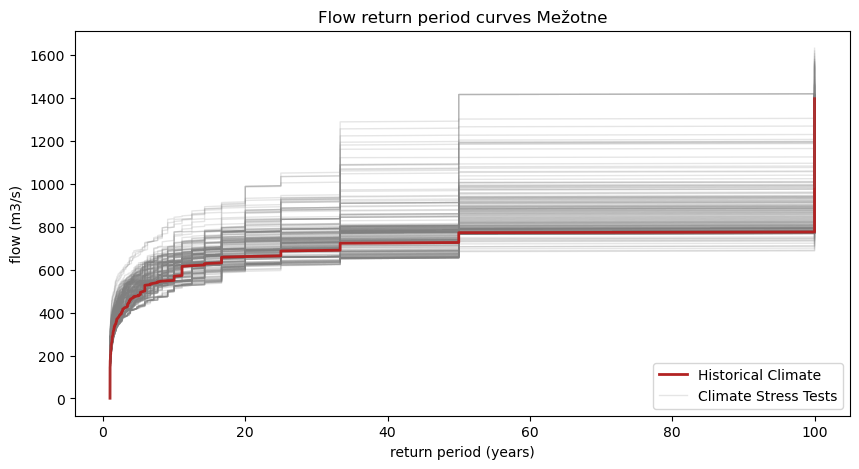

In [6]:
import numpy as np

fig, ax = plt.subplots(figsize=(10, 5))


flow_stats = pd.DataFrame(columns=['flow', 'N_occurrences', 'N_exceeding', 'rate', 'T', 'p'])

dates = station_of_interest_cst.index

n_years = 100

total_samples = len(station_of_interest_cst)


max_flow = station_of_interest_cst.max().max()

step_nr = 500
flow_steps = np.linspace(1, max_flow, step_nr)

for cst in available_cst:
    try:
        flow_cst_df = station_of_interest_cst[cst]

        block_maxima = flow_cst_df.resample('Y').max()

        # append row to df with 0 values for all dates
        for i in range(len(flow_steps)):
            class_bottom = flow_steps[i]
            # count the amount of dates where the flow is lower than the class_bottom
            n_occ = len(block_maxima[block_maxima < class_bottom])
            n_exceeding = len(block_maxima[block_maxima >= class_bottom])
            if n_exceeding > 0:
                rate = n_exceeding / (n_years)
                T = 1/rate
                p = 1 - np.exp(-1/T)
            else:
                rate = np.nan
                T = np.nan
                p = np.nan

            flow_stats.loc[i] = [class_bottom,
                                n_occ,
                                n_exceeding,
                                rate,
                                T,
                                p]

        # plot the risk curve
        if cst == 0:
            ax.plot(flow_stats['T'], flow_stats['flow'], color='firebrick', marker='', linestyle='-', linewidth=2, label='Historical Climate', zorder=1)
        else:
            ax.plot(flow_stats['T'], flow_stats['flow'], color='grey', marker='', linestyle='-', linewidth=1, alpha=0.2, zorder=0)
    except:
        pass

# add a legend label for the grey lines
        
ax.plot(flow_stats['T'], flow_stats['flow'], color='grey', marker='', linestyle='-', linewidth=1, alpha=0.2, label='Climate Stress Tests')
plt.legend(loc='lower right')
plt.title(f'Flow return period curves Mežotne')
plt.ylabel('flow (m3/s)')
plt.xlabel('return period (years)')

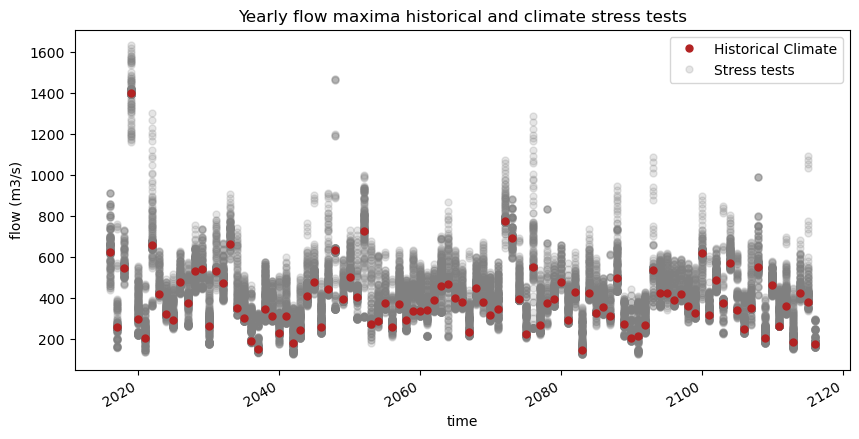

In [7]:
# for every cst obtain the yearly maxima
# sort the yearly maxima in descending order
fig, ax = plt.subplots(figsize=(10, 5))

for cst in available_cst:
    try:
        flow_cst_df = station_of_interest_cst[cst]

        block_maxima = flow_cst_df.resample('Y').max()

        # sort the block maxima
        block_maxima = block_maxima.sort_values(ascending=False)

        # plot the block maxima
        if cst == 0:
            block_maxima.plot(ax=ax, color='firebrick', marker='o', linestyle='', markersize=5, label='Historical Climate', zorder=1)
        else:
            block_maxima.plot(ax=ax, color='grey', marker='o', linestyle='', markersize=5, alpha=0.2, zorder=0, label=None)
    except:
        pass

ax.title.set_text('Yearly flow maxima historical and climate stress tests')

plt.ylabel('flow (m3/s)')
plt.xlabel('time')

# set legend handles
handles, labels = ax.get_legend_handles_labels()
# only keep first two
handles = handles[:2]
labels = ['Historical Climate', 'Stress tests']
ax.legend(handles, labels)

In [8]:
#############################
######## Using RPs ##########
#############################
T_values = [100/1, 100/2, 100/3, 100/4, 100/5]
stat_outcomes_flood_df = pd.DataFrame(columns=T_values)

for cst in available_cst:
    try:
        flow_cst_df = station_of_interest_cst[cst]

        block_maxima = flow_cst_df.resample('Y').max().values
        # append row 
        row = sorted(block_maxima, reverse=True)[0:len(T_values)]
        # block_maxima_max = np.max(block_maxima)
        # row_max = np.max(row)

        # print(block_maxima_max, row_max)

        stat_outcomes_flood_df.loc[cst] = row
     
    except:
        pass


# only keep 5, 10, 20, 50, 100
stat_outcomes_flood_df = stat_outcomes_flood_df.loc[:, [20, 50, 100]]
stat_outcomes_flood_df

,20.0,50.0,100.0
0,662.291173,774.303520,1398.360036
1,658.644767,772.479997,1395.595797
2,658.639287,772.655738,1396.639227
3,687.888916,772.803394,1397.574695
4,689.667389,772.931994,1398.473334
...,...,...,...
252,801.257563,912.284336,1400.511282
253,745.350014,817.346915,1401.160397
254,781.295235,875.677770,1401.281630
255,822.457265,931.232756,1401.406901


In [9]:
# create perentage change df
stat_outcomes_flood_df= stat_outcomes_flood_df / stat_outcomes_flood_df.loc[0, :]
stat_outcomes_flood_df = (stat_outcomes_flood_df - 1) * 100

([<matplotlib.axis.XTick at 0x18f145c7ed0>,
 [Text(1, 0, '20'), Text(2, 0, '50'), Text(3, 0, '100')])

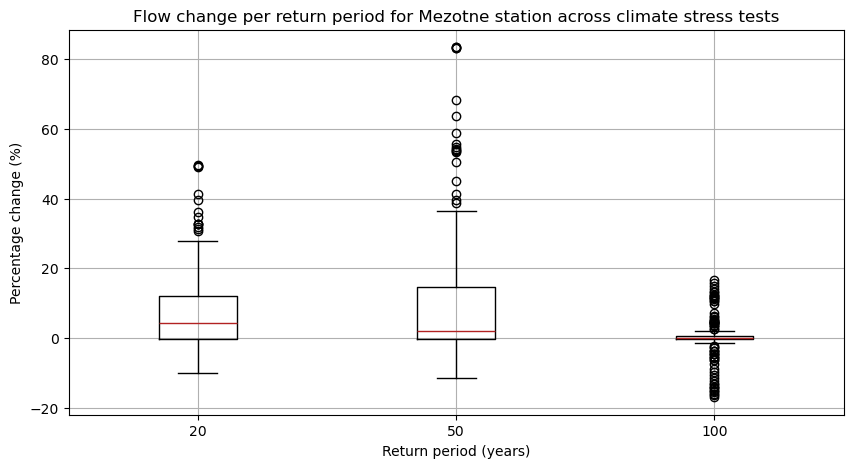

In [10]:
# create boxplots of the outcomes
fig, ax = plt.subplots(figsize=(10, 5))
box = stat_outcomes_flood_df.boxplot(ax=ax,return_type='dict', color='k')

for median in box['medians']:
    median.set_color('firebrick')  # Change color to red
    median.set_linewidth(1)

# set title
plt.title('Flow change per return period for Mezotne station across climate stress tests')
plt.ylabel('Percentage change (%)')
plt.xlabel('Return period (years)')

# set xlables :.2f
plt.xticks(np.arange(len(stat_outcomes_flood_df.columns)) +1, [f'{int(c)}' for c in stat_outcomes_flood_df.columns])


### Feature importance

In [ ]:
# scenario_list[scenario_list.index == stat_outcomes_flood_df.index]

# only keep scenarios for which there are also resuls
scenario_list = scenario_list[scenario_list.index.isin(stat_outcomes_flood_df.index)]
scenario_list

,DecFeb_dP,DecFeb_dP_var,DecFeb_dT,MarMay_dP,MarMay_dP_var,MarMay_dT,JunAug_dP,JunAug_dP_var,JunAug_dT,SepNov_dP,SepNov_dP_var,SepNov_dT
cst,,,,,,,,,,,,
0,1.000000,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
1,0.970358,0.887857,0.081848,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
2,0.970358,0.981079,0.081848,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
3,0.970358,1.074301,0.081848,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
4,0.970358,1.167523,0.081848,1.0,1.0,0.0,1.0,1.0,0.0,1.000000,1.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
252,1.000000,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.171053,1.251590,8.517426
253,1.000000,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.325684,0.885204,8.517426
254,1.000000,1.000000,0.000000,1.0,1.0,0.0,1.0,1.0,0.0,1.325684,1.007332,8.517426


In [12]:
# convert stat_outcomes_flood_df to dictionary with return periods as keys
stat_outcomes_flood_dict = {}
for T in stat_outcomes_flood_df.columns:
    stat_outcomes_flood_dict[T] = stat_outcomes_flood_df[T].values

In [13]:
x = scenario_list
y = stat_outcomes_flood_dict
feature_scores = feature_scoring.get_feature_scores_all(x, y, alg='extra trees', mode=RuleInductionType.REGRESSION, random_state =42, nr_trees=250)

new_heatmap = feature_scores.reindex(['DecFeb_dP', 'DecFeb_dP_var', 'DecFeb_dT','MarMay_dP', 'MarMay_dP_var', 'MarMay_dT','JunAug_dP', 'JunAug_dP_var', 'JunAug_dT','SepNov_dP', 'SepNov_dP_var', 'SepNov_dT'])


# remove name of column
new_heatmap.index.name = None

In [14]:
new_heatmap

# loop over the row indexes and replace them with new names
for i in range(len(new_heatmap.index)):
    # change all x and y axis labels
        # get current label
        old_xlabel = new_heatmap.index[i]

        # set new label
        new_xlabel = old_xlabel.replace(f'_', ' ')

        season_label_x = old_xlabel.split('_')[0]


        # change x and y labels to go from from season to month listing and dp to Δ
        if season_label_x == 'DecFeb':
            months_x = 'DJF'
        elif season_label_x == 'MarMay':
            months_x = 'MAM'
        elif season_label_x == 'JunAug':
            months_x = 'JJA'
        elif season_label_x == 'SepNov':
            months_x = 'SON'

        

        new_xlabel = new_xlabel.replace(f'{season_label_x}', months_x)

        new_xlabel = new_xlabel.replace(f'd', 'Δ')

        if 'var' in new_xlabel:
            new_xlabel = new_xlabel.replace('ΔP var', 'ΔCV')

        new_heatmap.rename(index={old_xlabel: new_xlabel}, inplace=True)

new_heatmap

,20.0,50.0,100.0
DJF ΔP,0.117626,0.177690,0.015370
DJF ΔCV,0.025317,0.031408,0.001557
DJF ΔT,0.135958,0.239349,0.004843
MAM ΔP,0.047587,0.077680,0.068837
MAM ΔCV,0.003134,0.052055,0.833751
MAM ΔT,0.007150,0.009291,0.070475
JJA ΔP,0.302084,0.244331,0.000933
JJA ΔCV,0.052775,0.062869,0.000377
JJA ΔT,0.033185,0.026493,0.001622
SON ΔP,0.176740,0.047400,0.000586


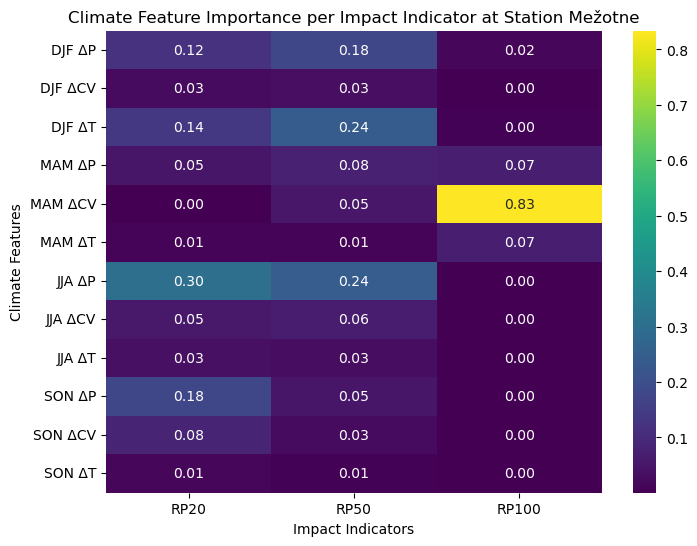

In [15]:
plt.figure(figsize=(8, 6))

sns.heatmap(new_heatmap, annot=True, cmap="viridis", fmt='.2f')

# replace x ticks
plt.xticks(np.arange(3) +0.5, ['RP20', 'RP50', 'RP100'])



plt.title(f"Climate Feature Importance per Impact Indicator at Station Mežotne")
plt.ylabel("Climate Features")
plt.xlabel("Impact Indicators")
plt.show()

## Response surfaces

In [16]:
def get_levels(min_value, max_value, step):
    # Correcting the calculation for start and end values considering begin_value
    if min_value % step == 0:
        begin_value = min_value  # Include the max_value if it's exactly on an interval
    else:
        begin_value = step * (-1 + int(min_value / step))  # Adjust to include max_value if not on interval

    if max_value % step == 0:
        end_value = max_value + 1  # Include the max_value if it's exactly on an interval
    else:
        end_value = step * (1 + int(max_value / step)) + 1  # Adjust to include max_value if not on interval
    
    # Generate array
    return list(range(begin_value, end_value, step))

def climate_response_surface_plt(str_results = None,
                            xaxis_variable = "temp",
                            yaxis_variable = "precip",
                            response_variable = None, 
                            response_threshold = None, 
                            response_direction = 0, 
                            cbar_min = None,
                            cbar_max = None,
                            cbar_orientation = "vertical",
                            ax=ax,
                            detail =10,
                            percentage_plot = True):
   
    """
    Function to create a climate response surface
    """

    main_font = "Overpass"
   
    # Set low and high colors based on increasing performance response_direction 
    if response_direction == 0:
        color_high = "blue"
        color_low = "red"
    else:
        color_high = "red"
        color_low = "blue"
    if percentage_plot == True:
        # check if xaxis and yaxis variable contain dT or dP
        if 'dT' in xaxis_variable:
            x = str_results[f"{xaxis_variable}"]
        else:
            x = (str_results[f"{xaxis_variable}"] - 1) * 100
        
        if 'dT' in yaxis_variable:
            y = str_results[f"{yaxis_variable}"]
        else:
            y = (str_results[f"{yaxis_variable}"] - 1) * 100
        
        
    else:
        x = str_results[f"{xaxis_variable}"]
        y = str_results[f"{yaxis_variable}"]
    
        
    z = str_results[response_variable]

    # Threshold value
    threshold = response_threshold

    # Create a colormap: blue for below threshold, red for above threshold
    colors = [color_low, 'white', color_high]
    cmap = LinearSegmentedColormap.from_list("above_below_threshold", colors)

    # Normalization centered at the threshold value
    norm = TwoSlopeNorm(vmin=cbar_min, vcenter=threshold, vmax=cbar_max)

    # Create grid values for contour
    xi = np.linspace(min(x), max(x), 100)
    yi = np.linspace(min(y), max(y), 100)
    X, Y = np.meshgrid(xi, yi)
    Z = griddata((x, y), z, (X, Y), method='linear')

    # Plot filled contour
    # contourf = ax.contourf(X, Y, Z, levels=np.linspace(cbar_min, cbar_max, detail), cmap=cmap, norm=norm)
    levels = get_levels(cbar_min, cbar_max, detail)
    contourf = ax.contourf(X, Y, Z, levels=levels, cmap=cmap, norm=norm)
    ax.set_aspect('auto')

    # Add a colorbar with the threshold from cbar_min to cbar_max
    cbar = plt.colorbar(contourf, orientation=cbar_orientation)

    # set cbar label
    cbar.set_label(f'% changes')
    # cbar.set_ticks([min(z), threshold, max(z)])

    # Set the threshold in the middle of the colorbar
    cbar.dividers.set_linewidth(0)
    cbar.dividers.set_color('black')

    # set black lines at 10% intervals
    # countour_levels = np.linspace(cbar_min, cbar_max, 5)
    # cbar.set_ticks(countour_levels)
    #ax.contour(X, Y, Z, levels=countour_levels, colors='black' )
    # ax.clabel(ax.contour(X, Y, Z, levels=countour_levels, colors='black' ), inline=True, fontsize=10, fmt='%1.0f') 
    

    # Add black contour line at the threshold
    ax.contour(X, Y, Z, levels=[threshold], colors='black')
    # add black contour lines at 10% intervals and set label inside the contour

    
    # Draw a black line on the colorbar at the threshold
    cbar.ax.hlines(threshold, 0, 1, colors='black', linestyles='solid')
    
    ax.set_xlabel(f'{xaxis_variable}')
    ax.set_ylabel(f'{yaxis_variable}')

def gcm_scatter_plt(gcm_df,
                    xaxis_variable, 
                    yaxis_variable,
                    ax,
                    rcp_means = True,
                    timeframe = "all",
                    grey_out = False,
                    opacity = 1,
                    percentage_plot = True):
    # only keep xaixs and yaxis variable
    gcm_df = gcm_df.loc[:, [f"{xaxis_variable}", f"{yaxis_variable}"]]

    # convert to percentages
    if percentage_plot == True:
        # only change columns that contain dP
        columns_to_change = [gcm_df.columns[i] for i in range(len(gcm_df.columns)) if "dP" in gcm_df.columns[i]]
        gcm_df[columns_to_change] = (gcm_df[columns_to_change] - 1) * 100
        # gcm_df = (gcm_df-1) * 100
    else:
        pass

    # subset in timeframe
    if timeframe != "all":
        gcm_df = gcm_df.loc[gcm_df.index.str.contains(timeframe)]
    else:
        pass

    # subset all rows in ssps
    ssp126 = gcm_df[gcm_df.index.str.contains("ssp126")]
    ssp245 = gcm_df[gcm_df.index.str.contains("ssp245")]
    ssp370 = gcm_df[gcm_df.index.str.contains("ssp370")]
    ssp460 = gcm_df[gcm_df.index.str.contains("ssp460")]
    ssp585 = gcm_df[gcm_df.index.str.contains("ssp585")]

    # plot each ssp scenario
    if grey_out == True:
        ssp126.plot.scatter(x=f"{xaxis_variable}", y=f"{yaxis_variable}", ax=ax, color='grey', edgecolors='black', linewidth=0.6, alpha=opacity)
        ssp245.plot.scatter(x=f"{xaxis_variable}", y=f"{yaxis_variable}", ax=ax, color='grey', edgecolors='black', linewidth=0.6, alpha=opacity, label='GCM projection')
        ssp370.plot.scatter(x=f"{xaxis_variable}", y=f"{yaxis_variable}", ax=ax, color='grey', edgecolors='black', linewidth=0.6, alpha=opacity)
        # ssp460.plot.scatter(x=f"{xaxis_variable}", y=f"{yaxis_variable}", ax=ax, color='grey', edgecolors='black', linewidth=0.6, alpha=opacity)
        ssp585.plot.scatter(x=f"{xaxis_variable}", y=f"{yaxis_variable}", ax=ax, color='grey', edgecolors='black', linewidth=0.6, alpha=opacity)
    else:
        ssp126.plot.scatter(x=f"{xaxis_variable}", y=f"{yaxis_variable}", ax=ax, label='ssp126', color='#0000FF', edgecolors='black', linewidth=0.5, alpha=opacity)
        ssp245.plot.scatter(x=f"{xaxis_variable}", y=f"{yaxis_variable}", ax=ax, label='ssp245', color='#79BCFF', edgecolors='black', linewidth=0.5, alpha=opacity)
        ssp370.plot.scatter(x=f"{xaxis_variable}", y=f"{yaxis_variable}", ax=ax, label='ssp370', color='#FF822D', edgecolors='black', linewidth=0.5, alpha=opacity)
        # ssp460.plot.scatter(x=f"{season}_{xaxis_variable}", y=f"{season}_{yaxis_variable}", ax=ax, label='ssp460', color='#FF822D', edgecolors='black', linewidth=0.5, alpha=opacity)
        ssp585.plot.scatter(x=f"{xaxis_variable}", y=f"{yaxis_variable}", ax=ax, label='ssp585', color='#FF0000', edgecolors='black', linewidth=0.5, alpha=opacity)

    if rcp_means == True:
        # get the mean xaxis variable and y axis variable per ssp and plot them as triangels
        ssp126_mean = ssp126.mean()
        ssp245_mean = ssp245.mean()
        ssp370_mean = ssp370.mean()
        # ssp460_mean = ssp460.mean()
        ssp585_mean = ssp585.mean()

        ax.scatter(ssp126_mean[f"{xaxis_variable}"], ssp126_mean[f"{yaxis_variable}"], marker='o', label='ssp126_mean', color='#0000FF', edgecolors='black', linewidth=0.5, s=100)
        ax.scatter(ssp245_mean[f"{xaxis_variable}"], ssp245_mean[f"{yaxis_variable}"], marker='o', label='ssp245_mean', color='#79BCFF', edgecolors='black', linewidth=0.5, s=100)
        ax.scatter(ssp370_mean[f"{xaxis_variable}"], ssp370_mean[f"{yaxis_variable}"], marker='o', label='ssp370_mean', color='#FF822D', edgecolors='black', linewidth=0.5, s=100)
        # ax.scatter(ssp460_mean[f"{xaxis_variable}"], ssp460_mean[f"{yaxis_variable}"], markero'^', label='ssp460_mean', color='#FF822D', edgecolors='black', linewidth=0.5, s=200)
        ax.scatter(ssp585_mean[f"{xaxis_variable}"], ssp585_mean[f"{yaxis_variable}"], marker='o', label='ssp585_mean', color='#FF0000', edgecolors='black', linewidth=0.5, s=100)

        mean_array = np.array([ssp126_mean, ssp245_mean, ssp370_mean, ssp585_mean])
        return mean_array      

def seasonal_response_surface(str_results = None,
                            season = None, 
                            response_variable = None, 
                            response_direction = 0, 
                            gcm_df = None,
                            timeframe = "all",
                            detail=12,
                            rcp_means = True):
    # create new plt figure
    fig,axs = plt.subplots(2,2, figsize=(10, 9))

    # overall settings
    timeframe = timeframe # 2021, 2041, 2081, all
    season = season
    stat = response_variable

    cbar_min = stat_outcomes_flood_df[stat].min()   
    cbar_max = stat_outcomes_flood_df[stat].max()


    # Plot climate response surface
    # get value closed to 0
    third_var_potential_threshold = str_results[(str_results[f'{season}_dP'] != 1) & (str_results[f'{season}_dP_var'] != 1)][f'{season}_dT'].unique()
    third_var_threshold = third_var_potential_threshold[np.argmin(np.abs(third_var_potential_threshold))]

    str_results_plot = str_results[(str_results[f'{season}_dP'] != 1) & (str_results[f'{season}_dP_var'] != 1) & (str_results[f'{season}_dT'] == third_var_threshold)] 
    fig1 = climate_response_surface_plt(str_results = str_results_plot,
                            xaxis_variable = f"{season}_dP",
                            yaxis_variable = f"{season}_dP_var",
                            response_variable = stat, 
                            response_threshold = str_results[stat][0], 
                            response_direction = 1, 
                            cbar_min = cbar_min,
                            cbar_max = cbar_max,
                            ax=axs[0][0],
                            detail=detail)

    # scatterplot for gcm projections
    fig1 = gcm_scatter_plt(gcm_df = gcm_df,
                    xaxis_variable = f"{season}_dP",
                    yaxis_variable = f"{season}_dP_var",
                    ax=axs[0][0],
                    timeframe = timeframe,
                    rcp_means=rcp_means) # 2021, 2041, 2081

    third_var_potential_threshold = str_results[(str_results[f'{season}_dT'] != 0) & (str_results[f'{season}_dP_var'] != 1)][f'{season}_dP'].unique()
    third_var_threshold = third_var_potential_threshold[np.argmin(np.abs(third_var_potential_threshold))]

    str_results_plot = str_results[(str_results[f'{season}_dP'] == third_var_threshold) & (str_results[f'{season}_dP_var'] != 1) & (str_results[f'{season}_dT'] != 0)] 
    fig1 = climate_response_surface_plt(str_results = str_results_plot, 
                            xaxis_variable = f"{season}_dP_var",
                            yaxis_variable = f"{season}_dT",
                            response_variable = stat, 
                            response_threshold = str_results[stat][0], 
                            response_direction = 1, 
                            cbar_min = cbar_min,
                            cbar_max = cbar_max,
                            ax=axs[1][1],
                            detail=detail)

    # scatterplot for gcm projections
    fig1 = gcm_scatter_plt(gcm_df = gcm_df,
                    xaxis_variable = f"{season}_dP_var",
                    yaxis_variable = f"{season}_dT",
                    ax=axs[1][1],
                    timeframe = timeframe,
                    rcp_means=rcp_means) # 2021, 2041, 2081

    third_var_potential_threshold = str_results[(str_results[f'{season}_dT'] != 0) & (str_results[f'{season}_dP'] != 1)][f'{season}_dP_var'].unique()
    third_var_threshold = third_var_potential_threshold[np.argmin(np.abs(third_var_potential_threshold))]

    str_results_plot = str_results[(str_results[f'{season}_dP'] != 1) & (str_results[f'{season}_dP_var'] == third_var_threshold) & (str_results[f'{season}_dT'] != 0)] 
    fig1 = climate_response_surface_plt(str_results = str_results_plot, 
                            xaxis_variable = f"{season}_dP",
                            yaxis_variable = f"{season}_dT",
                            response_variable = stat, 
                            response_threshold = str_results[stat][0], 
                            response_direction = 1,
                            cbar_min = cbar_min,
                            cbar_max = cbar_max, 
                            ax=axs[1][0],
                            detail=detail)

    # scatterplot for gcm projections
    fig1 = gcm_scatter_plt(gcm_df = gcm_df,
                    xaxis_variable = f"{season}_dP",
                    yaxis_variable = f"{season}_dT",
                    ax=axs[1][0],
                    timeframe = timeframe,
                    rcp_means=rcp_means) # 2021, 2041, 2081


    # remove ax
    # axs[0][1].remove()


    # copy legend and place legend in axs[0][1]
    handles, labels = axs[0][0].get_legend_handles_labels()

    if rcp_means == True:
        handles = handles[4:8]
        labels = labels[4:8]
    else:
        handles = handles[0:4]
        labels = labels[0:4]

    # set legend and size
    axs[0][1].legend(handles, labels, loc='center', fontsize=15, markerscale=1)

    # remove axis
    axs[0][1].axis('off')

    # remove all other legends
    axs[0][0].legend_.remove()
    axs[1][0].legend_.remove()
    axs[1][1].legend_.remove()


    if timeframe == "all":
        plt.suptitle(f'Stress test {season} for RP {stat} for all timeframes')
    else:
        plt.suptitle(f'Stress test {season} for RP {stat} in timeframe {int(timeframe)}-{int(timeframe)+20}')

# find impact values at specific location
def response_surface_value_from_x_y(str_results, xaxis_variable, yaxis_variable,response_variable, x_specific, y_specific, percentages_gcm = True):
    """
    Function to get the z value from a response surface
    """

    if percentages_gcm == True:
        x = (str_results[f"{xaxis_variable}"] - 1) * 100
        y = (str_results[f"{yaxis_variable}"] - 1) * 100
    else:
        x = str_results[f"{xaxis_variable}"]
        y = str_results[f"{yaxis_variable}"]
    z = str_results[response_variable]

    z_specific = griddata((x, y), z, (x_specific, y_specific), method='linear')
    return float(z_specific)

# find impact exploration range
def impact_range(str_results, response_variable, xaxis_variable, yaxis_variable, coordinates = None):
    coordinate_impact_values = []
    for coordinate in coordinates:
       coordinate_impact_values.append(response_surface_value_from_x_y(str_results, response_variable=response_variable, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable,  x_specific=coordinate[0], y_specific=coordinate[1]))

    range = [min(coordinate_impact_values), max(coordinate_impact_values), ]
    return range

In [17]:
# read in gcm data
gcm_df = pd.read_csv(f'./results/Latvia_all_models_dT_dP_dP_var.csv', index_col=0)
# divide all values for columns with 'dP' by 100 and add 1
gcm_df.loc[:, gcm_df.columns.str.contains('dP')] = gcm_df.loc[:, gcm_df.columns.str.contains('dP')] / 100 + 1

In [18]:
#  create a table of models used per ssp
used_models_df = pd.DataFrame()

for ssp in ['ssp126', 'ssp245', 'ssp370', 'ssp585']:
    models = gcm_df.index[gcm_df.index.str.contains(ssp)]
    used_models = []
    for model in models:
        # check if there are values for the model and ssp combination
        is_nan = gcm_df.loc[model].isnull().values.any()
        if not is_nan:
            used_models.append(model)
        else:
            pass

    # replace ssp and timeframe from model name
    used_models = [model.replace(f'_{ssp}', '') for model in used_models]
    used_models = [model.replace(f'_2021', '') for model in used_models]
    used_models = [model.replace(f'_2041', '') for model in used_models]
    used_models = [model.replace(f'_2081', '') for model in used_models]
    #  remove duplicates
    used_models = np.unique(used_models)
    df = pd.DataFrame(used_models, columns=[ssp])

    # concat to used_models_df
    used_models_df= pd.concat([used_models_df, df], axis=1)

In [19]:
import pandas as pd

df = used_models_df

# Create a set of unique model names
unique_models = pd.unique(df[['ssp126', 'ssp245', 'ssp370', 'ssp585']].values.ravel('K'))

# Initialize the new DataFrame
model_presence_df = pd.DataFrame(index=unique_models, columns=df.columns)

# Populate the DataFrame with ticks
for ssp in df.columns:
    model_presence_df[ssp] = model_presence_df.index.isin(df[ssp])

# .replace({True: '✓', False: ''})
model_presence_df = model_presence_df.replace({True: '✓', False: ''})
model_presence_df

,ssp126,ssp245,ssp370,ssp585
access_cm2,✓,✓,✓,✓
bcc_csm2_mr,✓,✓,✓,✓
canesm5,✓,,,✓
cesm2,✓,✓,✓,✓
cmcc_esm2,✓,✓,,✓
cnrm_cm6_1,✓,✓,✓,✓
cnrm_cm6_1_hr,✓,,,✓
cnrm_esm2_1,✓,✓,✓,✓
fgoals_g3,✓,✓,✓,✓
gfdl_esm4,✓,✓,✓,✓


In [20]:
# conctat flow_Stats and scenario_list
str_results = pd.concat([stat_outcomes_flood_df, scenario_list], axis=1)

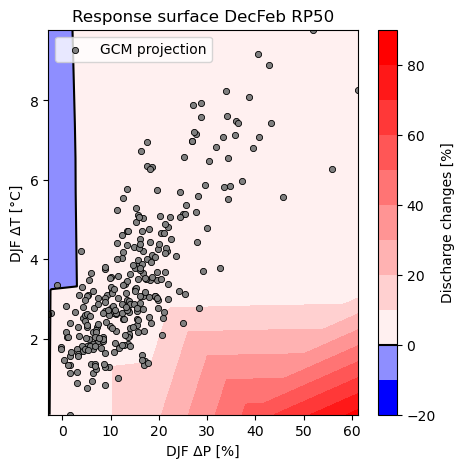

In [21]:
# create new plt figure
fig,ax = plt.subplots(1,1, figsize=(5, 5))

# overall settings
timeframe = 'all' # 2021, 2041, 2081, all
season = f'DecFeb'
stat = 50

cbar_min = stat_outcomes_flood_df[stat].min()   
cbar_max = stat_outcomes_flood_df[stat].max()

third_var_potential_threshold = str_results[(str_results[f'{season}_dT'] != 0) & (str_results[f'{season}_dP'] != 1)][f'{season}_dP_var'].unique()
third_var_threshold = third_var_potential_threshold[np.argmin(np.abs(third_var_potential_threshold))]

# Plot climate response surface
str_results_plot = str_results[(str_results[f'{season}_dP'] != 1) & (str_results[f'{season}_dT'] != 1) & (str_results[f'{season}_dP_var'] == third_var_threshold)] 
fig1 = climate_response_surface_plt(str_results = str_results_plot,
                        xaxis_variable = f"DecFeb_dP",
                        yaxis_variable = f"DecFeb_dT",
                        response_variable = stat, 
                        response_threshold = str_results[stat][0], 
                        response_direction = 1, 
                        cbar_min = cbar_min,
                        cbar_max = cbar_max,
                        ax=ax,
                        detail=10)

# scatterplot for gcm projections
fig1 = gcm_scatter_plt(gcm_df = gcm_df,
                xaxis_variable = f"DecFeb_dP",
                yaxis_variable = f"DecFeb_dT",
                ax=ax,
                timeframe = timeframe,
                grey_out=True,
                rcp_means=False) # 2021, 2041, 2081

ax.legend_.remove()
        
# change all x and y axis labels
# get current label
old_xlabel = ax.get_xlabel()
old_ylabel = ax.get_ylabel()

# set new label
new_xlabel = old_xlabel.replace(f'_', ' ') + ' [%]'
new_ylabel = old_ylabel.replace(f'_', ' ') + ' [°C]'

# change x and y labels to go from from season to month listing and dp to Δ
if season == 'DecFeb':
    months = 'DJF'
elif season == 'MarMay':
    months = 'MAM'
elif season == 'JunAug':
    months = 'JJA'
elif season == 'SepNov':
    months = 'SON'

new_xlabel = new_xlabel.replace(f'{season}', months)
new_ylabel = new_ylabel.replace(f'{season}', months)

new_xlabel = new_xlabel.replace(f'd', 'Δ')
new_ylabel = new_ylabel.replace(f'd', 'Δ')

ax.set_xlabel(new_xlabel)
ax.set_ylabel(new_ylabel)

# set colorbar label for ax
ax.collections[0].colorbar.set_label(f'Discharge changes [%]')

ax.set_ylim((str_results_plot[f'{season}_dT'].min()), (str_results_plot[f'{season}_dT'].max()))

# set title
ax.set_title(f'Response surface {season} RP{stat}')


# add a legend label for the ssps
plt.legend(loc='upper left')


In [22]:
bonus_cst = pd.read_csv(f'./data/hydrological_runs/station_{station_to_analyse}_cst_aggregate_bonus_runs.csv', index_col=0, parse_dates=True)
available_cst = bonus_cst.columns[0:]


T_values = [100/1, 100/2, 100/3, 100/4, 100/5]
stat_outcomes_flood_bonus_df = pd.DataFrame(columns=T_values)

for cst in available_cst:
    flow_cst_df = bonus_cst[cst]

    block_maxima = flow_cst_df.resample('Y').max().values
    # append row 
    row = sorted(block_maxima, reverse=True)[0:len(T_values)]
    # block_maxima_max = np.max(block_maxima)
    # row_max = np.max(row)

    # print(block_maxima_max, row_max)

    stat_outcomes_flood_bonus_df.loc[cst] = row
    

# set index to int
stat_outcomes_flood_bonus_df.index = stat_outcomes_flood_bonus_df.index.astype(int)

# only keep 5, 10, 20, 50, 100
stat_outcomes_flood_bonus_df = stat_outcomes_flood_bonus_df.loc[:, [20, 50, 100]]
# create perentage change df
stat_outcomes_flood_bonus_df= stat_outcomes_flood_bonus_df / stat_outcomes_flood_bonus_df.loc[0, :]
stat_outcomes_flood_bonus_df = (stat_outcomes_flood_bonus_df - 1) * 100

# load bonus scenario list
scenario_list_bonus = pd.read_csv(f'./data/hydrological_runs/total_scenario_list_bonus_runs.csv', index_col=0)
scenario_list_bonus = scenario_list_bonus.set_index('cst', drop=True)

#### multiple timeframes

C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\2072251776.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] = (gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] - 1) * 100
c:\Users\buskop\AppData\Local\anaconda3\envs\cst_flood\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\2072251776.py:109: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.py

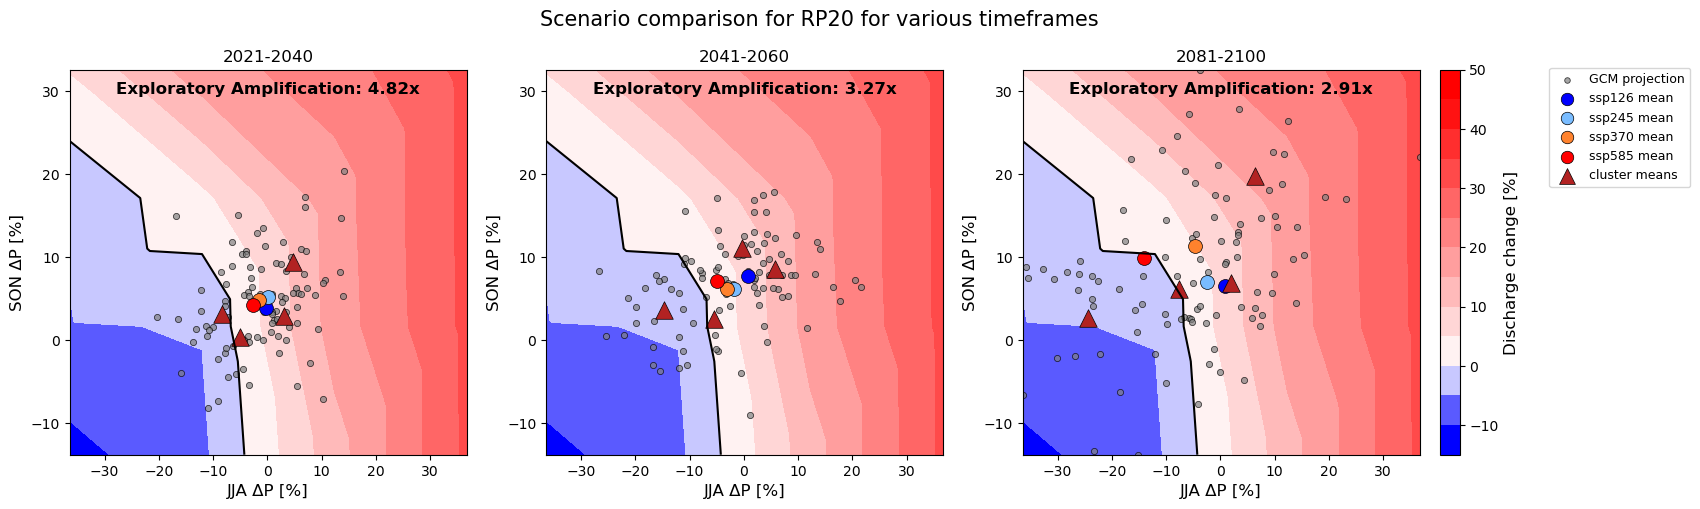

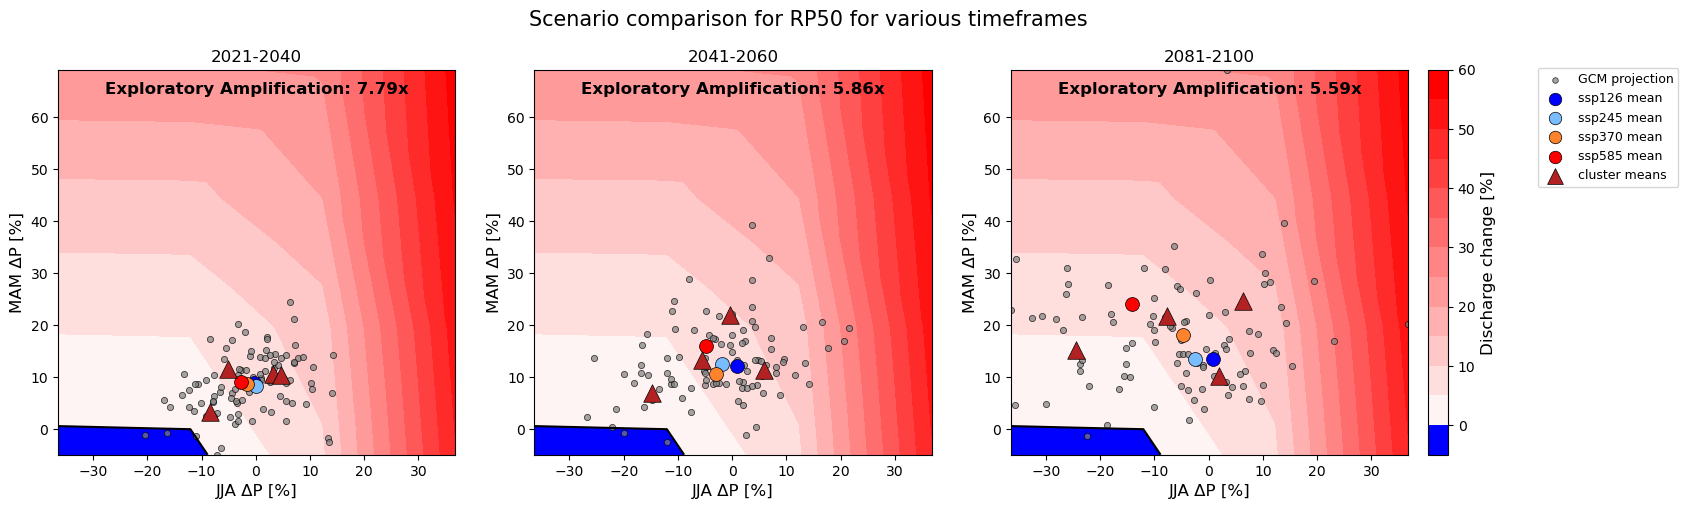

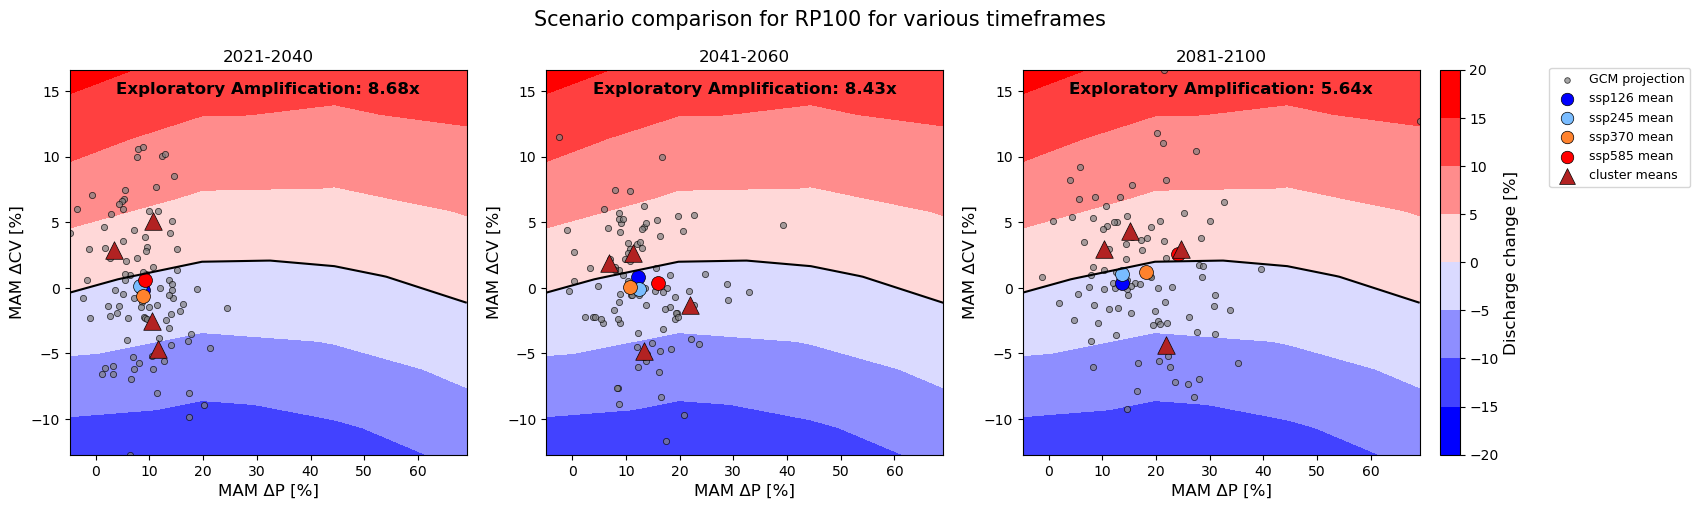

In [23]:
# create new plt figure
vertical_figure = False
stats = [20,50,100] 
for stat in stats:
    
    if vertical_figure == True:
        fig,axs = plt.subplots(3,1, figsize=(6, 18))
        impact_range_text_x = 0.4
        impact_range_text_y = 1.15

        legend_pos_x = 0.5
        legend_pos_y = 102
        ncols=3

        cbar_orientation = 'horizontal'

    else:
        fig,axs = plt.subplots(1,3, figsize=(20, 5))
        impact_range_text_x = 0.5
        impact_range_text_y = 1.15

        legend_pos_x = 9
        legend_pos_y = 0.85
        ncols = 1

        cbar_orientation = 'vertical'

    # overall settings
    if stat == 20:
        xaxis_variable = 'JunAug_dP'
        yaxis_variable = 'SepNov_dP'
        cbar_min = stat_outcomes_flood_bonus_df[stat].min()   
        cbar_max = stat_outcomes_flood_bonus_df[stat].max()

        str_results = pd.concat([stat_outcomes_flood_bonus_df, scenario_list_bonus], axis=1)

        str_results_plot = str_results[(str_results[xaxis_variable] != 1) & (str_results[yaxis_variable] != 1)] 
        # str_results_plot = str_results_plot.append(str_results[str_results.index == 0])


    if stat == 50:
        xaxis_variable = 'JunAug_dP'
        yaxis_variable = 'MarMay_dP'
        cbar_min = stat_outcomes_flood_bonus_df[stat].min()   
        cbar_max = stat_outcomes_flood_bonus_df[stat].max()

        str_results = pd.concat([stat_outcomes_flood_bonus_df, scenario_list_bonus], axis=1)

        str_results_plot = str_results[(str_results[xaxis_variable] != 1) & (str_results[yaxis_variable] != 1)] 


    if stat == 100:
            xaxis_variable = 'MarMay_dP'
            yaxis_variable = 'MarMay_dP_var'
            cbar_min = stat_outcomes_flood_df[stat].min()   
            cbar_max = stat_outcomes_flood_df[stat].max()

            str_results = pd.concat([stat_outcomes_flood_df, scenario_list], axis=1)

            if xaxis_variable or yaxis_variable == 'MarMay_dP':
                third_var_threshold = str_results[(str_results[yaxis_variable] != 1) & (str_results[xaxis_variable] != 1)][f'MarMay_dT'].unique().min()
                str_results_plot = str_results[(str_results[yaxis_variable] != 1) & (str_results[xaxis_variable] != 1) & (str_results[f'MarMay_dT'] == third_var_threshold)]

            elif xaxis_variable or yaxis_variable == 'MarMay_dT':
                third_var_threshold = str_results[(str_results[yaxis_variable] != 0) & (str_results[xaxis_variable] != 1)][f'MarMay_dP'].unique().min()
                str_results_plot = str_results[(str_results[yaxis_variable] != 1) & (str_results[xaxis_variable] != 1) & (str_results[f'MarMay_dP'] == third_var_threshold)] 


    

    # plot cluster centers
    timeframes = ['2021', '2041', '2081'] # 'all'
    for i, timeframe in enumerate(timeframes):
        # set title
        if timeframe == 'all':
            axs[i].set_title(f'all')
        else:
            axs[i].set_title(f'{timeframe}-{int(timeframe)+19}')

        # Plot climate response surface
        fig1 = climate_response_surface_plt(str_results = str_results_plot,
                                xaxis_variable = xaxis_variable,
                                yaxis_variable = yaxis_variable,
                                response_variable = stat, 
                                response_threshold = str_results[stat][0], 
                                response_direction = 1, 
                                cbar_min = cbar_min,
                                cbar_max = cbar_max,
                                cbar_orientation = cbar_orientation,
                                ax=axs[i],
                                detail=5)

        # scatterplot for gcm projections
        mean_array = gcm_scatter_plt(gcm_df = gcm_df,
                                    xaxis_variable = xaxis_variable,
                                    yaxis_variable = yaxis_variable,
                                    ax=axs[i],
                                    timeframe = timeframe,  # 2021, 2041, 2081
                                    grey_out=True,
                                    opacity=0.7)
        
        impact_range_values_ssp = impact_range(str_results_plot, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable, response_variable=stat, coordinates= mean_array)

        var_of_interest = ['MarMay_dP', 'MarMay_dP_var', 'SepNov_dP', 'JunAug_dP']

        gcm_df_of_interest = gcm_df[var_of_interest]

        # convert the columns containing dp to percentages
        gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] = (gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] - 1) * 100

        if timeframe == 'all':
            gcm_df_of_interest_timeframe = gcm_df_of_interest.dropna()
        else:
            gcm_df_of_interest_timeframe = gcm_df_of_interest[gcm_df_of_interest.index.str.contains(timeframe)].dropna()


        # # cluster the gcm data
        

        # Standardize the data
        scaler = StandardScaler()
        gcm_df_of_interest_timeframe_scaled = scaler.fit_transform(gcm_df_of_interest_timeframe)
        # gcm_df_of_interest_timeframe_scaled = gcm_df_of_interest_timeframe

        # Create a KMeans instance with 3 clusters: model
        model = KMeans(n_clusters=4, random_state=111, n_init=2000)

        # Fit model to points
        model.fit(gcm_df_of_interest_timeframe_scaled)

        # Determine the cluster labels of new_points: labels
        labels = model.predict(gcm_df_of_interest_timeframe_scaled)
        centers = model.cluster_centers_
        # rescale centers
        centers = scaler.inverse_transform(centers)
        centers_df = pd.DataFrame(centers, columns=var_of_interest)

        # plot cluste centers
        axs[i].scatter(centers_df[xaxis_variable], centers_df[yaxis_variable], c='firebrick', s=160, alpha=1, edgecolors='black', linewidth=0.5, label='cluster means', marker='^')

        # add small text below the plot
        impact_range_values_new = impact_range(str_results_plot, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable, response_variable=stat, coordinates= centers_df[[xaxis_variable, yaxis_variable]].values)

        # find range extension 
        ssp_impact_range_size = impact_range_values_ssp[1] - impact_range_values_ssp[0]
        new_impact_range_size = impact_range_values_new[1] - impact_range_values_new[0]
        range_extension = (new_impact_range_size-ssp_impact_range_size)/(ssp_impact_range_size) * 100
        range_multiplication = (new_impact_range_size)/(ssp_impact_range_size)
        axs[i].text(impact_range_text_x, impact_range_text_y -0.2, f'Exploratory Amplification: {round(range_multiplication,2)}x', 
                    horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes, fontsize=12, weight='bold')

    if vertical_figure == True:
        plt.suptitle(f'Scenario comparison for RP{stat} for various timeframes', y=0.91, fontsize=15)
    else:
        plt.suptitle(f'Scenario comparison for RP{stat} for various timeframes', y=1, fontsize=15)

    # plt.colorbar(cax=axs)

    # drop cbar from the first two subplots
    axs[0].collections[0].colorbar.remove()
    axs[1].collections[0].colorbar.remove()
    cbar = axs[2].collections[0].colorbar
    axs[2].collections[0].colorbar.remove()


    

    fig.subplots_adjust(right=0.8)  # Make room for colorbar

    if vertical_figure == True:
        subplot_pos = axs[2].get_position()  
        bottom = subplot_pos.y0
        height = subplot_pos.height
        width = subplot_pos.width
        x0 = subplot_pos.x0
        cbar_ax = fig.add_axes([x0, bottom-0.05, width, 0.008])
    else:
        subplot_pos = axs[0].get_position()  
        bottom = subplot_pos.y0
        height = subplot_pos.height
        cbar_ax = fig.add_axes([0.81, bottom, 0.01, height])  # Adjust these values as needed

    cbar_overall = fig.colorbar(cbar.mappable, cax=cbar_ax, orientation = cbar_orientation)
    cbar_overall.set_label('Discharge change [%]', fontsize=12)


    handles = axs[0].get_legend_handles_labels()[0]
    labels = axs[0].get_legend_handles_labels()[1]
    # remove _ from all labels
    labels = [label.replace('_', ' ') for label in labels]

    # remove legends
    for ax in axs:
        ax.legend_.remove()
        
        # change all x and y axis labels
        # get current label
        old_xlabel = ax.get_xlabel()
        old_ylabel = ax.get_ylabel()

        # set new label
        new_xlabel = old_xlabel.replace(f'_', ' ') + ' [%]'
        new_ylabel = old_ylabel.replace(f'_', ' ') + ' [%]'

        season_label_x = old_xlabel.split('_')[0]
        season_label_y = old_ylabel.split('_')[0]


        # change x and y labels to go from from season to month listing and dp to Δ
        if season_label_x == 'DecFeb':
            months_x = 'DJF'
        elif season_label_x == 'MarMay':
            months_x = 'MAM'
        elif season_label_x == 'JunAug':
            months_x = 'JJA'
        elif season_label_x == 'SepNov':
            months_x = 'SON'

        if season_label_y == 'DecFeb':
            months_y = 'DJF'
        elif season_label_y == 'MarMay':
            months_y = 'MAM'
        elif season_label_y == 'JunAug':
            months_y = 'JJA'
        elif season_label_y == 'SepNov':
            months_y = 'SON'

        new_xlabel = new_xlabel.replace(f'{season_label_x}', months_x)
        new_ylabel = new_ylabel.replace(f'{season_label_y}', months_y)

        new_xlabel = new_xlabel.replace(f'd', 'Δ')
        new_ylabel = new_ylabel.replace(f'd', 'Δ')

        if 'var' in new_xlabel:
            new_xlabel = new_xlabel.replace('ΔP var', 'ΔCV')
        if 'var' in  new_ylabel:
            new_ylabel = new_ylabel.replace('ΔP var', 'ΔCV')

        ax.set_xlabel(new_xlabel, fontsize=12) 
        ax.set_ylabel(new_ylabel, fontsize=12)

        ax.tick_params(axis='both',which='both', labelsize=10)

    
    # create space for legend    
    plt.legend(handles, labels, fontsize=9, markerscale=0.9, loc='center', bbox_to_anchor=(legend_pos_x, legend_pos_y), ncol=ncols)
    
    if vertical_figure == True:
        fig.subplots_adjust(top=0.83)


### multiple RPs

C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\628019708.py:119: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] = (gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] - 1) * 100
c:\Users\buskop\AppData\Local\anaconda3\envs\cst_flood\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\628019708.py:163: UserWarning: *c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its

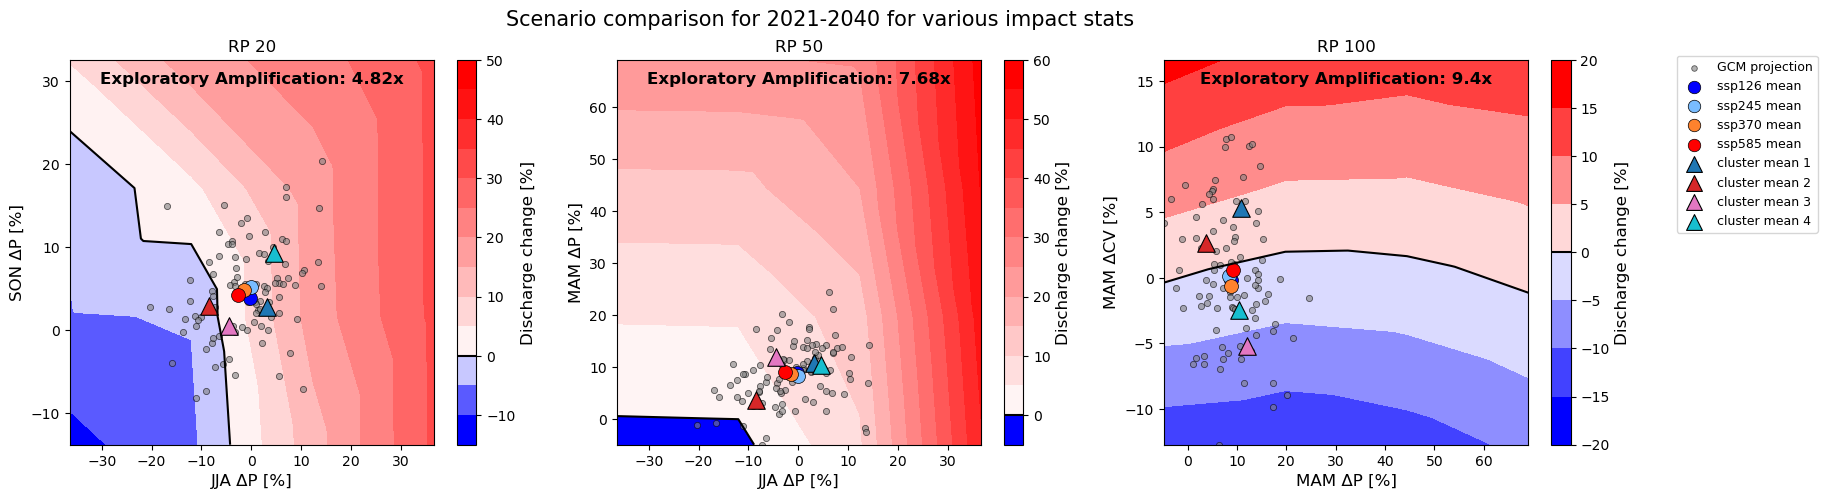

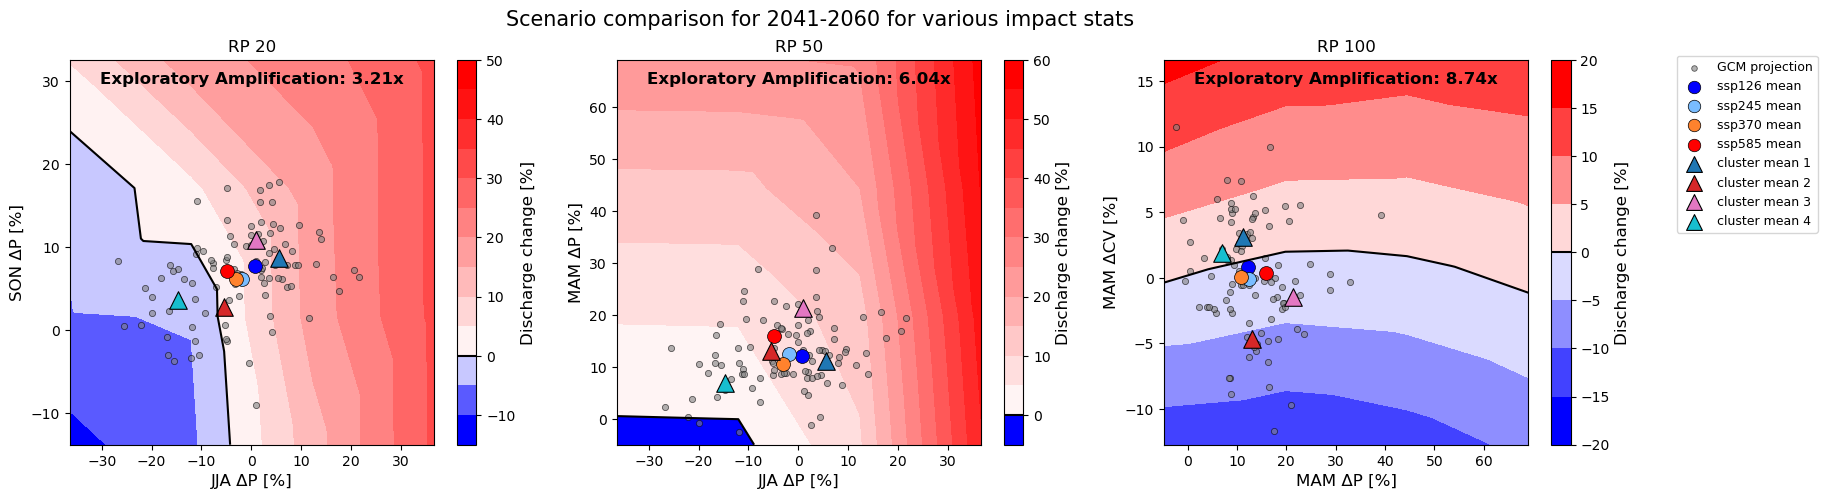

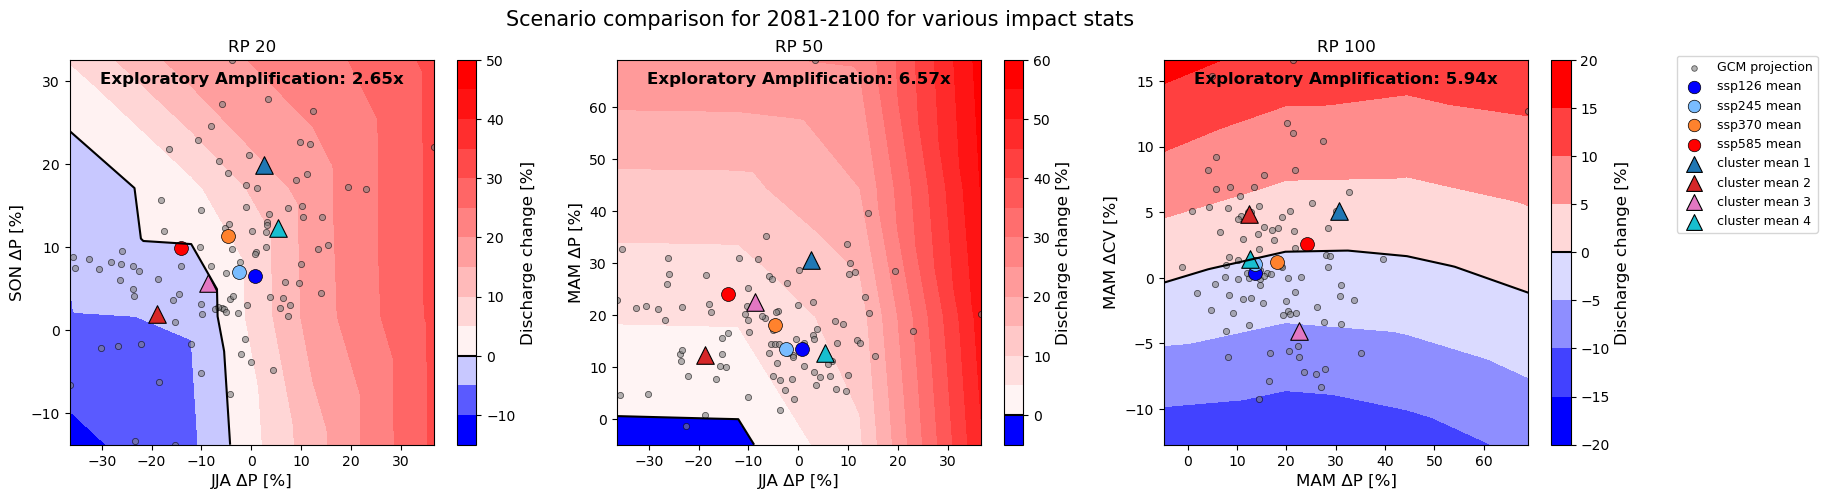

In [24]:
scale_features = True
vertical_figure = False

timeframes = ['2021', '2041', '2081']

# resulting cluster groups
gcms_clustered = []

for timeframe in timeframes:

    # create new plt figure
    if vertical_figure == True:
        fig,axs = plt.subplots(3,1, figsize=(6, 17))
        impact_range_text_x = 0.43
        impact_range_text_y = 1.15

        legend_pos_x = 0.6
        legend_pos_y = 3.6
        ncols = 4

        cbar_orientation = 'vertical'
    
    else:
        fig,axs = plt.subplots(1,3, figsize=(20, 5))
        impact_range_text_x = 0.5
        impact_range_text_y = 1.15

        legend_pos_x = 1.6
        legend_pos_y = 0.78
        ncols = 1
    # overall settings
    stat = 20




    # plot cluster centers
    stats = [20,50,100]

    for i, stat in enumerate(stats):
    # set title
        if timeframe == 'all':
            axs[i].set_title(f'all')
        else:
            axs[i].set_title(f'RP {stat}')

            # overall settings
        if stat == 20:
            xaxis_variable = 'JunAug_dP'
            yaxis_variable = 'SepNov_dP'
            cbar_min = stat_outcomes_flood_bonus_df[stat].min()   
            cbar_max = stat_outcomes_flood_bonus_df[stat].max()

            str_results = pd.concat([stat_outcomes_flood_bonus_df, scenario_list_bonus], axis=1)

            str_results_plot = str_results[(str_results[xaxis_variable] != 1) & (str_results[yaxis_variable] != 1)] 
            # str_results_plot = pd.concat([str_results_plot, str_results[str_results.index == 0]])


        if stat == 50:
            xaxis_variable = 'JunAug_dP'
            yaxis_variable = 'MarMay_dP'
            cbar_min = stat_outcomes_flood_bonus_df[stat].min()   
            cbar_max = stat_outcomes_flood_bonus_df[stat].max()

            str_results = pd.concat([stat_outcomes_flood_bonus_df, scenario_list_bonus], axis=1)

            str_results_plot = str_results[(str_results[xaxis_variable] != 1) & (str_results[yaxis_variable] != 1)] 
            # str_results_plot = pd.concat([str_results_plot, str_results[str_results.index == 0]])


    

        if stat == 100:
            xaxis_variable = 'MarMay_dP'
            yaxis_variable = 'MarMay_dP_var'
            cbar_min = stat_outcomes_flood_df[stat].min()   
            cbar_max = stat_outcomes_flood_df[stat].max()

            str_results = pd.concat([stat_outcomes_flood_df, scenario_list], axis=1)

            if xaxis_variable or yaxis_variable == 'MarMay_dP':
                third_var_threshold = str_results[(str_results[yaxis_variable] != 1) & (str_results[xaxis_variable] != 1)][f'MarMay_dT'].unique().min()
                str_results_plot = str_results[(str_results[yaxis_variable] != 1) & (str_results[xaxis_variable] != 1) & (str_results[f'MarMay_dT'] == third_var_threshold)]

            elif xaxis_variable or yaxis_variable == 'MarMay_dT':
                third_var_threshold = str_results[(str_results[yaxis_variable] != 0) & (str_results[xaxis_variable] != 1)][f'MarMay_dP'].unique().min()
                str_results_plot = str_results[(str_results[yaxis_variable] != 1) & (str_results[xaxis_variable] != 1) & (str_results[f'MarMay_dP'] == third_var_threshold)]

       # Plot climate response surface
        fig1 = climate_response_surface_plt(str_results = str_results_plot,
                                xaxis_variable = xaxis_variable,
                                yaxis_variable = yaxis_variable,
                                response_variable = stat, 
                                response_threshold = str_results[stat][0], 
                                response_direction = 1, 
                                cbar_min = cbar_min,
                                cbar_max = cbar_max,
                                cbar_orientation = cbar_orientation,
                                ax=axs[i],
                                detail=5)

        # scatterplot for gcm projections
        mean_array = gcm_scatter_plt(gcm_df = gcm_df,
                                    xaxis_variable = xaxis_variable,
                                    yaxis_variable = yaxis_variable,
                                    ax=axs[i],
                                    timeframe = timeframe,  # 2021, 2041, 2081
                                    grey_out=True,
                                    opacity=0.6)
        
        impact_range_values_ssp = impact_range(str_results_plot, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable, response_variable=stat, coordinates= mean_array)

        var_of_interest = ['MarMay_dP','MarMay_dP_var', 'SepNov_dP', 'JunAug_dP']

        gcm_df_of_interest = gcm_df[var_of_interest]
        # gcm_df_of_interest['MarMay_dP_var_2'] = gcm_df_of_interest['MarMay_dP_var']
        # rename the last columns
        gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] = (gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] - 1) * 100


        if timeframe == 'all':
            gcm_df_of_interest_timeframe = gcm_df_of_interest.dropna()
        else:
            gcm_df_of_interest_timeframe = gcm_df_of_interest[gcm_df_of_interest.index.str.contains(timeframe)].dropna()


        # # cluster the gcm data
        from sklearn.cluster import KMeans, BisectingKMeans
        from sklearn.preprocessing import StandardScaler

        # Standardize the data
        scaler = StandardScaler()
        if scale_features == True:
            gcm_df_of_interest_timeframe_scaled = scaler.fit_transform(gcm_df_of_interest_timeframe)
        
        else:
            gcm_df_of_interest_timeframe_scaled = gcm_df_of_interest_timeframe

        # Create a KMeans instance with 3 clusters: model
        model = KMeans(n_clusters=4, random_state=111, n_init='auto') # "auto"

        # Fit model to points
        model.fit(gcm_df_of_interest_timeframe_scaled)

        # Determine the cluster labels of new_points: labels
        gcm_df_of_interest_timeframe['cluster'] = model.labels_
        gcms_clustered.append(gcm_df_of_interest_timeframe)
        
        centers = model.cluster_centers_
        # rescale centers
        if scale_features == True:
            centers = scaler.inverse_transform(centers)
    
        centers_df = pd.DataFrame(centers, columns=gcm_df_of_interest.columns)

        # plot cluste centers
        tab10_colors = plt.get_cmap('tab10')
        norm = mcolors.Normalize(vmin=0, vmax=3)


        for index, row in centers_df.iterrows():
            axs[i].scatter(row[xaxis_variable], row[yaxis_variable], c=tab10_colors(norm(index)), s=160, alpha=1, edgecolors='black', linewidth=0.8, label=f'cluster mean {index+1}', marker='^')
        # axs[i].scatter(centers_df[f'{season}_dP'], centers_df[f'{season}_dP_var'], c=centers_df.index, cmap='tab10', s=150, alpha=1, edgecolors='black', linewidth=0.5, label='New scenario means')


        # add small text below the plot
        impact_range_values_new = impact_range(str_results_plot, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable, response_variable=stat, coordinates= centers_df[[xaxis_variable, yaxis_variable]].values)
      
        # find range extension 
        ssp_impact_range_size = impact_range_values_ssp[1] - impact_range_values_ssp[0]
        new_impact_range_size = impact_range_values_new[1] - impact_range_values_new[0]
        range_extension = (new_impact_range_size-ssp_impact_range_size)/(ssp_impact_range_size) * 100
        range_multiplication = (new_impact_range_size)/(ssp_impact_range_size)
        axs[i].text(impact_range_text_x, impact_range_text_y -0.2, f'Exploratory Amplification: {round(range_multiplication,2)}x', 
                    horizontalalignment='center', verticalalignment='center', transform=axs[i].transAxes, fontsize=12,
                     weight='bold')

    if timeframe == 'all':
        plt.suptitle(f'Scenario comparison for {timeframe}', fontsize = 15)
    else:
        plt.suptitle(f'Scenario comparison for {timeframe}-{int(timeframe)+19} for various impact stats', fontsize = 15)

    # change all x and y axis labels
    for ax in axs:
        # change all x and y axis labels
        # get current label
        old_xlabel = ax.get_xlabel()
        old_ylabel = ax.get_ylabel()

        # set new label
        new_xlabel = old_xlabel.replace(f'_', ' ') + ' [%]'
        new_ylabel = old_ylabel.replace(f'_', ' ') + ' [%]'

        season_label_x = old_xlabel.split('_')[0]
        season_label_y = old_ylabel.split('_')[0]


        # change x and y labels to go from from season to month listing and dp to Δ
        if season_label_x == 'DecFeb':
            months_x = 'DJF'
        elif season_label_x == 'MarMay':
            months_x = 'MAM'
        elif season_label_x == 'JunAug':
            months_x = 'JJA'
        elif season_label_x == 'SepNov':
            months_x = 'SON'

        if season_label_y == 'DecFeb':
            months_y = 'DJF'
        elif season_label_y == 'MarMay':
            months_y = 'MAM'
        elif season_label_y == 'JunAug':
            months_y = 'JJA'
        elif season_label_y == 'SepNov':
            months_y = 'SON'

        new_xlabel = new_xlabel.replace(f'{season_label_x}', months_x)
        new_ylabel = new_ylabel.replace(f'{season_label_y}', months_y)

        new_xlabel = new_xlabel.replace(f'd', 'Δ')
        new_ylabel = new_ylabel.replace(f'd', 'Δ')

        if 'var' in new_xlabel:
            new_xlabel = new_xlabel.replace('ΔP var', 'ΔCV')
        if 'var' in  new_ylabel:
            new_ylabel = new_ylabel.replace('ΔP var', 'ΔCV')

        ax.set_xlabel(new_xlabel, fontsize=12)
        ax.set_ylabel(new_ylabel, fontsize=12)

        # set colorbar label
        cbar = ax.collections[0].colorbar
        cbar.set_label('Discharge change [%]', fontsize=12)
        ax.title.set_fontsize(12)
        ax.tick_params(axis='both',which='both', labelsize=10)

    
    # create a leged
    handles = axs[0].get_legend_handles_labels()[0]
    labels = axs[0].get_legend_handles_labels()[1]
    # remove _ from all labels
    labels = [label.replace('_', ' ') for label in labels]

    # remove legends
    for ax in axs:
        ax.legend_.remove()
        # set axis limit to countour plot


    # create space for legend
    plt.legend(handles, labels, fontsize=9, markerscale=0.9, loc='center', bbox_to_anchor=(legend_pos_x, legend_pos_y), ncol=ncols)

    if vertical_figure == True:
        fig.subplots_adjust(top=0.89)

## cascade of uncertainty plot

C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\2193723740.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] = (gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] - 1) * 100
c:\Users\buskop\AppData\Local\anaconda3\envs\cst_flood\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\2193723740.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

<Figure size 640x480 with 0 Axes>

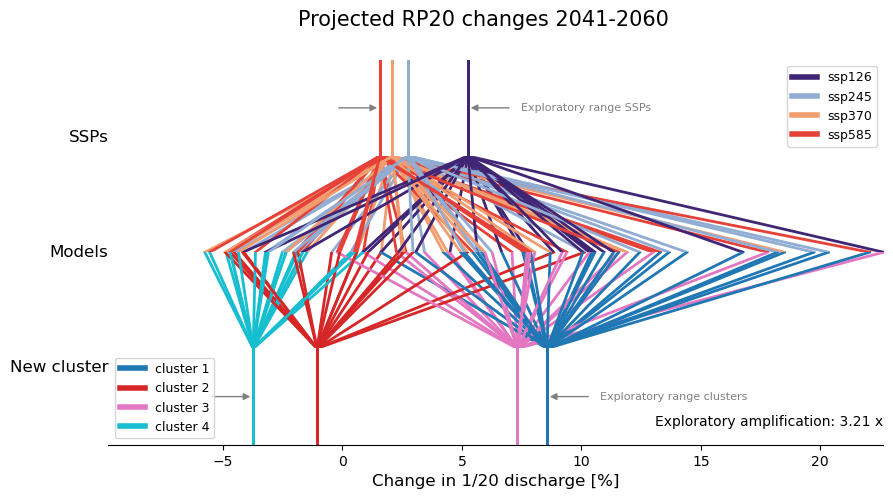

C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\2193723740.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] = (gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] - 1) * 100
c:\Users\buskop\AppData\Local\anaconda3\envs\cst_flood\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\2193723740.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

<Figure size 640x480 with 0 Axes>

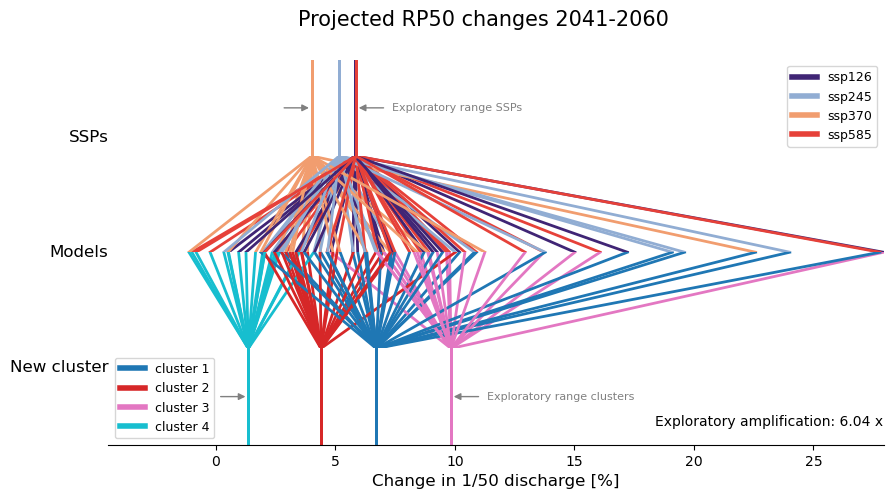

C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\2193723740.py:95: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] = (gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] - 1) * 100
c:\Users\buskop\AppData\Local\anaconda3\envs\cst_flood\Lib\site-packages\sklearn\cluster\_kmeans.py:1440: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  warnings.warn(
C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\2193723740.py:160: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pyd

<Figure size 640x480 with 0 Axes>

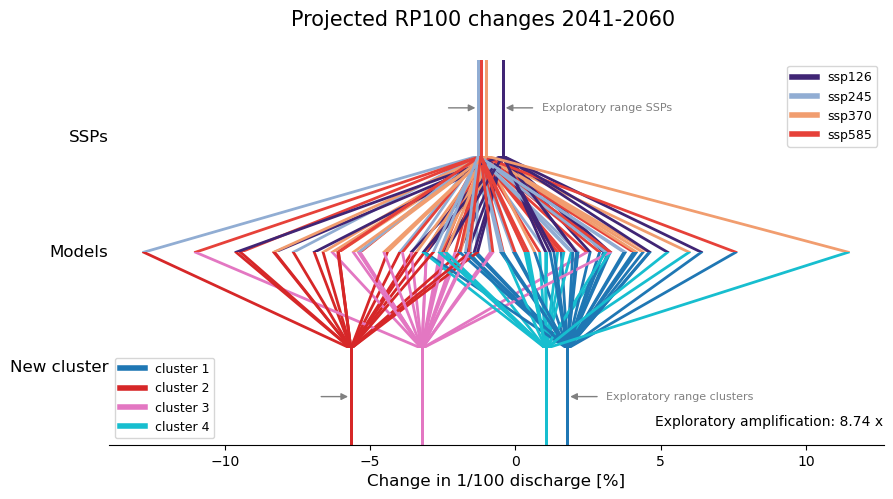

In [25]:
# # cluster the gcm data
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler


# resulting cluster groups
gcms_clustered = []

timeframe = '2041'

# plot cluster centers
stats = [20,50,100]


for i, stat in enumerate(stats):
    # overall settings
    if stat == 20:
        xaxis_variable = 'JunAug_dP'
        yaxis_variable = 'SepNov_dP'
        cbar_min = stat_outcomes_flood_bonus_df[stat].min()   
        cbar_max = stat_outcomes_flood_bonus_df[stat].max()

        str_results = pd.concat([stat_outcomes_flood_bonus_df, scenario_list_bonus], axis=1)
        str_results_plot = str_results[(str_results[xaxis_variable] != 1) & (str_results[yaxis_variable] != 1)] 


    if stat == 50:
        xaxis_variable = 'JunAug_dP'
        yaxis_variable = 'MarMay_dP'
        cbar_min = stat_outcomes_flood_bonus_df[stat].min()   
        cbar_max = stat_outcomes_flood_bonus_df[stat].max()

        str_results = pd.concat([stat_outcomes_flood_bonus_df, scenario_list_bonus], axis=1)
        str_results_plot = str_results[(str_results[xaxis_variable] != 1) & (str_results[yaxis_variable] != 1)] 


    if stat == 100:
        xaxis_variable = 'MarMay_dP'
        yaxis_variable = 'MarMay_dP_var'
        cbar_min = stat_outcomes_flood_df[stat].min()   
        cbar_max = stat_outcomes_flood_df[stat].max()

        str_results = pd.concat([stat_outcomes_flood_df, scenario_list], axis=1)

        if xaxis_variable or yaxis_variable == 'MarMay_dP':
            third_var_threshold = str_results[(str_results[yaxis_variable] != 1) & (str_results[xaxis_variable] != 1)][f'MarMay_dT'].unique().min()
            str_results_plot = str_results[(str_results[yaxis_variable] != 1) & (str_results[xaxis_variable] != 1) & (str_results[f'MarMay_dT'] == third_var_threshold)]

        elif xaxis_variable or yaxis_variable == 'MarMay_dT':
            third_var_threshold = str_results[(str_results[yaxis_variable] != 0) & (str_results[xaxis_variable] != 1)][f'MarMay_dP'].unique().min()
            str_results_plot = str_results[(str_results[yaxis_variable] != 1) & (str_results[xaxis_variable] != 1) & (str_results[f'MarMay_dP'] == third_var_threshold)]

    # Plot climate response surface
    fig1 = climate_response_surface_plt(str_results = str_results_plot,
                            xaxis_variable = xaxis_variable,
                            yaxis_variable = yaxis_variable,
                            response_variable = stat, 
                            response_threshold = str_results[stat][0], 
                            response_direction = 1, 
                            cbar_min = cbar_min,
                            cbar_max = cbar_max,
                            cbar_orientation = cbar_orientation,
                            ax=axs[i],
                            detail=5)

    # scatterplot for gcm projections
    mean_array = gcm_scatter_plt(gcm_df = gcm_df,
                                xaxis_variable = xaxis_variable,
                                yaxis_variable = yaxis_variable,
                                ax=axs[i],
                                timeframe = timeframe,  # 2021, 2041, 2081
                                grey_out=True,
                                opacity=0.6)
    
    spp_means_impact = []
    # add small text below the plot
    spp_means_coordinates = mean_array
    for coordinate in spp_means_coordinates:
       spp_means_impact.append(response_surface_value_from_x_y(str_results, response_variable=stat, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable,  x_specific=coordinate[0], y_specific=coordinate[1]))

    
    impact_range_values_ssp = impact_range(str_results_plot, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable, response_variable=stat, coordinates= mean_array)
    # if stat == 20:
    #     var_of_interest = ['SepNov_dP_var', 'SepNov_dP', 'JunAug_dP']
    # if stat == 50:
    #     var_of_interest = ['MarMay_dP', 'MarMay_dP_var']
    # if stat == 100:
    #     var_of_interest = ['MarMay_dP_var']

    var_of_interest = ['MarMay_dP','MarMay_dP_var', 'SepNov_dP', 'JunAug_dP']

    gcm_df_of_interest = gcm_df[var_of_interest]
    # gcm_df_of_interest['MarMay_dP_var_2'] = gcm_df_of_interest['MarMay_dP_var']
    # rename the last columns
    gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] = (gcm_df_of_interest.loc[:, gcm_df_of_interest.columns.str.contains('dP')] - 1) * 100


    if timeframe == 'all':
        gcm_df_of_interest_timeframe = gcm_df_of_interest.dropna()
    else:
        gcm_df_of_interest_timeframe = gcm_df_of_interest[gcm_df_of_interest.index.str.contains(timeframe)].dropna()




    # Standardize the data
    scaler = StandardScaler()
    gcm_df_of_interest_timeframe_scaled = scaler.fit_transform(gcm_df_of_interest_timeframe)
    
 
    # Create a KMeans instance with 3 clusters: model
    model = KMeans(n_clusters=4, random_state=111, n_init='auto') # "auto"

    # Fit model to points
    model.fit(gcm_df_of_interest_timeframe_scaled)

    # Determine the cluster labels of new_points: labels
    gcm_df_of_interest_timeframe['cluster'] = model.labels_
    gcms_clustered.append(gcm_df_of_interest_timeframe)

    # get individual impact of each model
    gcm_coordinate_impact_values = []
    coordinates = gcm_df_of_interest_timeframe[[xaxis_variable, yaxis_variable]].values
    for coordinate in coordinates:
       gcm_coordinate_impact_values.append(response_surface_value_from_x_y(str_results, response_variable=stat, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable,  x_specific=coordinate[0], y_specific=coordinate[1]))

    gcm_df_of_interest_timeframe['impact'] = gcm_coordinate_impact_values
    
    centers = model.cluster_centers_
    # rescale centers
    centers = scaler.inverse_transform(centers)

    centers_df = pd.DataFrame(centers, columns=gcm_df_of_interest.columns)

    cluster_centers_impact = []
    # add small text below the plot
    cluster_centers_coordinates = centers_df[[xaxis_variable, yaxis_variable]].values
    for coordinate in cluster_centers_coordinates:
       cluster_centers_impact.append(response_surface_value_from_x_y(str_results, response_variable=stat, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable,  x_specific=coordinate[0], y_specific=coordinate[1]))


    impact_range_values_new = impact_range(str_results_plot, xaxis_variable=xaxis_variable, yaxis_variable=yaxis_variable, response_variable=stat, coordinates= centers_df[[xaxis_variable, yaxis_variable]].values)

    # find range extension 
    ssp_impact_range_size = impact_range_values_ssp[1] - impact_range_values_ssp[0]
    new_impact_range_size = impact_range_values_new[1] - impact_range_values_new[0]
    range_extension = (new_impact_range_size-ssp_impact_range_size)/(ssp_impact_range_size) * 100
    range_multiplication = (new_impact_range_size)/(ssp_impact_range_size)


    # for all rows in the dataframe set model ssp
    gcm_df_of_interest_timeframe['ssp'] = gcm_df_of_interest_timeframe.index
    gcm_df_of_interest_timeframe['ssp_impact'] = np.nan

    # ssp126, ssp245, ssp370, ssp585
    spp_means_impact

    for i, entry in enumerate(gcm_df_of_interest_timeframe['ssp']):
        entry = entry.split('_')[-2]
        gcm_df_of_interest_timeframe['ssp'][i] = entry

        if entry == 'ssp126':
            gcm_df_of_interest_timeframe['ssp_impact'][i] = spp_means_impact[0]
        if entry == 'ssp245':
            gcm_df_of_interest_timeframe['ssp_impact'][i] = spp_means_impact[1]
        if entry == 'ssp370':
            gcm_df_of_interest_timeframe['ssp_impact'][i] = spp_means_impact[2]
        if entry == 'ssp585':
            gcm_df_of_interest_timeframe['ssp_impact'][i] = spp_means_impact[3]
            

    # cluster 1,2,3,4
    cluster_centers_impact

    gcm_df_of_interest_timeframe['cluster'] += 1
    gcm_df_of_interest_timeframe['cluster_impact'] = np.nan


    for i, entry in enumerate(gcm_df_of_interest_timeframe['cluster']):
        if entry == 1:
            gcm_df_of_interest_timeframe['cluster_impact'][i] = cluster_centers_impact[0]
        if entry == 2:
            gcm_df_of_interest_timeframe['cluster_impact'][i] = cluster_centers_impact[1]
        if entry == 3:
            gcm_df_of_interest_timeframe['cluster_impact'][i] = cluster_centers_impact[2]
        if entry == 4:
            gcm_df_of_interest_timeframe['cluster_impact'][i] = cluster_centers_impact[3]

    import matplotlib.pyplot as plt

    # create data
    cascade_info = gcm_df_of_interest_timeframe[['cluster', 'impact', 'ssp', 'ssp_impact', 'cluster_impact']]
    df = cascade_info

    # give RGB colors
    ssp126_blue = '#402575'
    ssp245_light_blue = '#91ADD3'
    ssp370_orange = "#F19D6F"
    ssp585_red = "#E64139"

    # set colors for ssp 126, 245, 370, 585
    colors = {'ssp585': ssp585_red, 'ssp370': ssp370_orange, 'ssp245': ssp245_light_blue, 'ssp126': ssp126_blue}


    # make subplots with vertical orientation
    fig, ax = plt.subplots(4, 1, figsize=(10, 5), sharex=True)

    # plot subplots and set y-limit
    for i in range(4):
        for entry in df.iterrows():
            ssp = entry[1]['ssp']
            cluster_nr = entry[1]['cluster']
            if i == 0:
                y = [entry[1]['ssp_impact'], entry[1]['ssp_impact']]
                x = ['ssp', 'ssp_extension']
                ax[i].plot(y, x, linewidth=2, color=colors[ssp], alpha=1)  # Switch x and y

            if i == 1:
                y = [entry[1]['impact'], entry[1]['ssp_impact']]
                x = ['ssp', 'model']
                ax[i].plot(y, x, linewidth=2, color=colors[ssp], alpha=1)  # Switch x and y
                # ax[i].plot(y[0], 0, marker='|', markersize=30,markeredgewidth=2, color=colors[ssp])  # Start

            if i == 2:
                y = [entry[1]['cluster_impact'], entry[1]['impact']]
                x = ['model','cluster']
                colors = plt.get_cmap('tab10')
                norm = mcolors.Normalize(vmin=1, vmax=4)

                ax[i].plot(y, x, linewidth=2, color=colors(norm(cluster_nr)), alpha=1)
                # ax[i].plot(y[1], 1, marker='|', markersize=30,markeredgewidth=2, color=colors(norm(cluster_nr)))  # End

            if i == 3:
                y = [entry[1]['cluster_impact'], entry[1]['cluster_impact']]
                x = ['cluster', 'cluster_extension']
                # set tab10 color
                colors = plt.get_cmap('tab10')
                norm = mcolors.Normalize(vmin=1, vmax=4)

                ax[i].plot(y, x, linewidth=2, color=colors(norm(cluster_nr)), alpha=1)


            
        ax[i].set_ylim([x[0],x[1]])

    #     # turn axis off
    ax[0].axis('off')
    ax[1].axis('off')
    ax[2].axis('off')
    # turn off spines
    ax[3].spines['top'].set_visible(False)
    ax[3].spines['right'].set_visible(False)
    ax[3].spines['left'].set_visible(False)
    ax[3].set_yticks([])

    # set xaxis title
    ax[3].set_xlabel(f'Change in 1/{stat} discharge [%]', fontsize=12)

    # set xlim for all subplots
    if stat == 20:
        plt.xlim([df['impact'].min()*1.7, df['impact'].max()])
    elif stat == 50:
        plt.xlim([df['impact'].min()*4, df['impact'].max()])
    # move xaxis with more distance to the plot

    # add title
    plt.suptitle(f'Projected RP{stat} changes {timeframe}-{int(timeframe)+19}', fontsize=15)

    # set height space to zero
    plt.subplots_adjust(hspace=0)

    ax[0].text(0, 0.2, f'SSPs', fontsize=12, weight='light', ha='right', va='center', transform=ax[0].transAxes)

    ax[1].text(0, 0, f'Models', fontsize=12, weight='light', ha='right', va='center', transform=ax[1].transAxes)

    ax[2].text(0, -0.2, f'New cluster', fontsize=12, weight='light', ha='right', va='center', transform=ax[2].transAxes)

    # add legend 
    handles = [plt.Line2D([0], [0], color=ssp126_blue, lw=4),
                plt.Line2D([0], [0], color=ssp245_light_blue, lw=4),
                plt.Line2D([0], [0], color=ssp370_orange, lw=4),
                plt.Line2D([0], [0], color=ssp585_red, lw=4)]

    labels = ['ssp126', 'ssp245', 'ssp370', 'ssp585']
    ax[0].legend(handles, labels, fontsize=9, loc='upper right')

    # add an extra legend
    handles = [plt.Line2D([0], [0], color=colors(norm(1)), lw=4),
                plt.Line2D([0], [0], color=colors(norm(2)), lw=4),
                plt.Line2D([0], [0], color=colors(norm(3)), lw=4),
                plt.Line2D([0], [0], color=colors(norm(4)), lw=4)]
    labels = ['cluster 1', 'cluster 2', 'cluster 3', 'cluster 4']
    ax[3].legend(handles, labels, fontsize=9, loc='lower left')

    # annotate the plot with range amplification
    # if stat == 100:
    ax[3].text(1, 0.2, f'Exploratory amplification: {range_multiplication:.2f} x', horizontalalignment='right', fontsize=10, weight='light', transform=ax[3].transAxes)
    # ax[0].text(0.3, 1, f'Exploratory amplification: {range_multiplication:.2f} x', horizontalalignment='right', fontsize=10, weight='light', transform=ax[0].transAxes, zorder=0)


    # 1. Calculate the Common Arrow Length
    # Find the overall range across both 'ssp_impact' and 'cluster_impact'
    overall_min = min(df['ssp_impact'].min(), df['cluster_impact'].min())
    overall_max = max(df['ssp_impact'].max(), df['cluster_impact'].max())
    overall_range = overall_max - overall_min

    # Decide on a fixed arrow length (e.g., 20% of the overall range)
    arrow_extension = overall_range * 0.15

    # 2. Adjust Arrow Starting Positions Using the Common Length

    # For the top subplot (ax[0])
    max_ssp_impact = df['ssp_impact'].max()
    min_ssp_impact = df['ssp_impact'].min()

    # Extend min and max by the fixed arrow length
    extended_min_ssp_impact = min_ssp_impact - arrow_extension
    extended_max_ssp_impact = max_ssp_impact + arrow_extension


    # Position on the y-axis (numeric positions corresponding to 'ssp_extension')
    y_position_top = 0.5  # Adjust if necessary based on your categorical axis mapping

    # Draw arrows pointing towards the min and max impact values from extended positions
    ax[0].annotate('', xy=(min_ssp_impact, y_position_top), xytext=(extended_min_ssp_impact, y_position_top),
                arrowprops=dict(arrowstyle='-|>', color='grey', lw=1))
    ax[0].annotate('', xy=(max_ssp_impact, y_position_top), xytext=(extended_max_ssp_impact, y_position_top),
                arrowprops=dict(arrowstyle='-|>', color='grey', lw=1))

    # For the bottom subplot (ax[3])
    max_cluster_impact = df['cluster_impact'].max()
    min_cluster_impact = df['cluster_impact'].min()

    # Use the same fixed arrow extension
    extended_min_cluster_impact = min_cluster_impact - arrow_extension
    extended_max_cluster_impact = max_cluster_impact + arrow_extension


    # Position on the y-axis (numeric positions corresponding to 'cluster_extension')
    y_position_bottom = 0.5  # Adjust if necessary based on your categorical axis mapping

    # Draw arrows pointing towards the min and max impact values from extended positions
    ax[3].annotate('', xy=(min_cluster_impact, y_position_bottom), xytext=(extended_min_cluster_impact, y_position_bottom),
                arrowprops=dict(arrowstyle='-|>', color='grey', lw=1))
    ax[3].annotate('', xy=(max_cluster_impact, y_position_bottom), xytext=(extended_max_cluster_impact, y_position_bottom),
                arrowprops=dict(arrowstyle='-|>', color='grey', lw=1))

    # 3. Annotate Arrows on the Right with 'Exploratory range'

    # Define the position for the annotation text
    text_offset = arrow_extension * 0.2

    # For the top subplot (ax[0])
    ax[0].text(extended_max_ssp_impact + text_offset, y_position_top, 'Exploratory range SSPs',
            verticalalignment='center', horizontalalignment='left', fontsize=8, color='grey')

    # For the bottom subplot (ax[3])
    ax[3].text(extended_max_cluster_impact + text_offset, y_position_bottom, 'Exploratory range clusters',
            verticalalignment='center', horizontalalignment='left', fontsize=8, color='grey')

    plt.show()

## cluster (box)plots

In [26]:
to_plot = gcms_clustered[0]

# add JunAug_dP and DecFeb_dP to to_plot from gcm_df
to_plot['JunAug_dP'] = (gcm_df['JunAug_dP'] -1) * 100
to_plot['JunAug_dP_var'] = (gcm_df['JunAug_dP'] -1) * 100

to_plot['DecFeb_dP'] = (gcm_df['DecFeb_dP'] -1) * 100
to_plot['DecFeb_dP_var'] = (gcm_df['DecFeb_dP'] -1) * 100

# add MarMay_dT and SepNov_dT to to_plot from gcm_df
to_plot['MarMay_dT'] = gcm_df['MarMay_dT']
to_plot['SepNov_dT'] = gcm_df['SepNov_dT']


C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\2828557797.py:31: UserWarning: When passing multiple axes, sharex and sharey are ignored. These settings must be specified when creating axes.
  bp_dict  = to_boxplot.boxplot(column=columns_to_plot, by='cluster', ax=axs, grid=False,


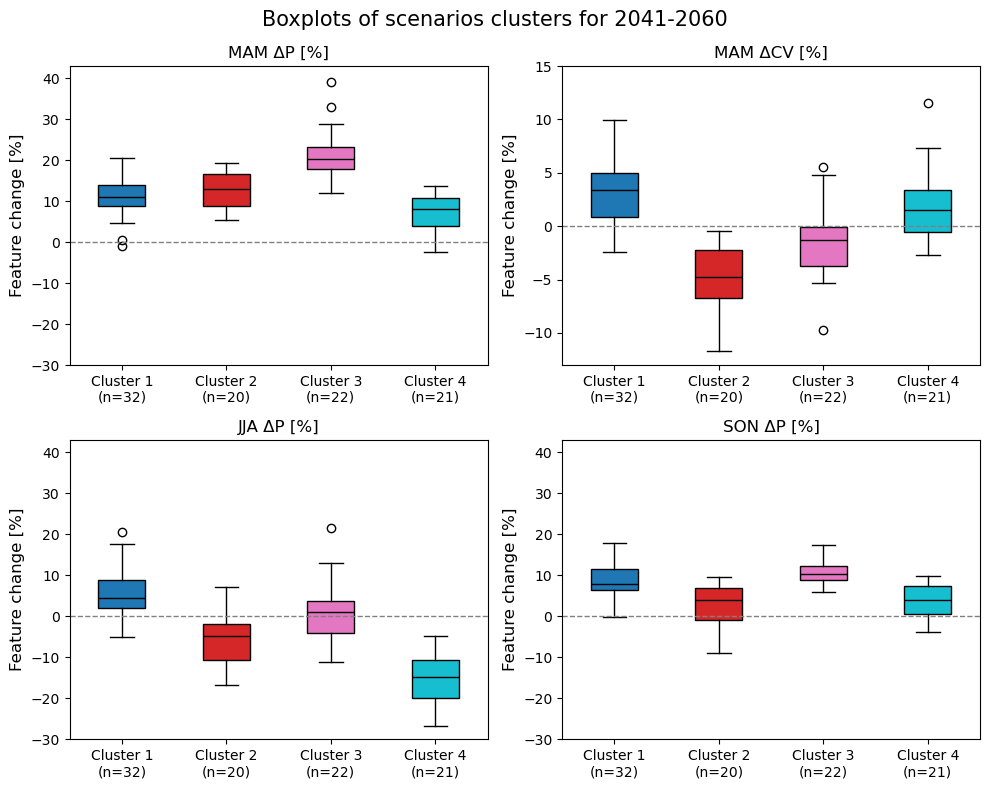

In [27]:
# per cluster create a boxplot

# Columns to plot
columns_to_plot = ['MarMay_dP', 'MarMay_dP_var', 'JunAug_dP', 'SepNov_dP']




# create new plt figure
layout = '2x2'
if layout == "4x1":
    fig, axs = plt.subplots(len(columns_to_plot), 1, figsize=(6, 3.5 * len(columns_to_plot)))
    title_plot_spacing = 0.93
elif layout == "2x2":
    fig, axs = plt.subplots(2, 2, figsize=(10, 8))
    axs = axs.flatten()
    title_plot_spacing = 0.91

to_boxplot = to_plot
to_boxplot['cluster'] = to_plot['cluster'] + 1


# create cmap tab10
tab10_colors = plt.get_cmap('tab10')
# normalize cmap between 0 and 4
norm = mcolors.Normalize(vmin=0, vmax=3)
colors = [tab10_colors(norm(i)) for i in range(4)]

c = 'k'

bp_dict  = to_boxplot.boxplot(column=columns_to_plot, by='cluster', ax=axs, grid=False,
            patch_artist=True, return_type='both',
            boxprops=dict(color=c),
            capprops=dict(color=c),
            whiskerprops=dict(color=c),
            flierprops=dict(color=c, markeredgecolor=c),
            medianprops=dict(color=c),
            )
for i in range(len(bp_dict)):
    for n in range(len(bp_dict.iloc[i][1]['boxes'])):
        box = bp_dict.iloc[i][1]['boxes'][n]
        box.set_facecolor(colors[n])
    

# loop over axes and add labels
for ax in axs:
    # remove xlabel
    ax.set_xlabel('')
    ax.set_ylabel('Feature change [%]', fontsize=12)
    # set hline at 0
    ax.axhline(0, color='grey', linewidth=1, linestyle='--')

    # set xticks size
    ax.tick_params(axis='both', labelsize=10)

    # set title
    ax.title.set_fontsize(12)

    # retrieve old title
    old_xlabel = ax.title.get_text()

    # set new title
    # set new label
    new_xlabel = old_xlabel.replace(f'_', ' ') + ' [%]'

    season_label_x = old_xlabel.split('_')[0]


    # change x and y labels to go from from season to month listing and dp to Δ
    if season_label_x == 'DecFeb':
        months_x = 'DJF'
    elif season_label_x == 'MarMay':
        months_x = 'MAM'
    elif season_label_x == 'JunAug':
        months_x = 'JJA'
    elif season_label_x == 'SepNov':
        months_x = 'SON'

    new_xlabel = new_xlabel.replace(f'{season_label_x}', months_x)

    new_xlabel = new_xlabel.replace(f'd', 'Δ')
    new_ylabel = new_ylabel.replace(f'd', 'Δ')

    if 'var' in new_xlabel:
        new_xlabel = new_xlabel.replace('ΔP var', 'ΔCV')

    ax.set_title(new_xlabel, fontsize=12)
    

    # per xtick set number of models
    cluster_nrs = np.sort(to_plot['cluster'].unique())
    ax.set_xticklabels([f'Cluster {i+1}\n(n={to_plot["cluster"].value_counts().loc[j]})' for i, j in enumerate(cluster_nrs)], fontsize=10)
    
#  set axis 1 and 3 y limits
axs[0].set_ylim(-30, 43)
axs[2].set_ylim(-30, 43)
axs[3].set_ylim(-30, 43)

axs[1].set_ylim(-13, 15)


# remove vertical lines in boxplots


# set title
plt.suptitle(f'Boxplots of scenarios clusters for {timeframe}-{int(timeframe)+19}', fontsize=15)

plt.tight_layout()

# set title a bit higher
plt.subplots_adjust(top=title_plot_spacing)

In [28]:
# get gcm entries with an index in cluster
cluster_nrs = np.sort(to_plot['cluster'].unique())

cluster_1 = to_plot[to_plot['cluster'] ==cluster_nrs[0]]
gcm_df_cluster_1 = gcm_df.loc[cluster_1.index]

cluster_2 = to_plot[to_plot['cluster'] == cluster_nrs[1]]
gcm_df_cluster_2 = gcm_df.loc[cluster_2.index]

cluster_3 = to_plot[to_plot['cluster'] == cluster_nrs[2]]
gcm_df_cluster_3 = gcm_df.loc[cluster_3.index]

cluster_4 = to_plot[to_plot['cluster'] == cluster_nrs[3]]
gcm_df_cluster_4 = gcm_df.loc[cluster_4.index]

# create a df with the mean values of the clusters
cluster_1_mean = gcm_df_cluster_1.mean()
cluster_2_mean = gcm_df_cluster_2.mean()
cluster_3_mean = gcm_df_cluster_3.mean()
cluster_4_mean = gcm_df_cluster_4.mean()

# create a df with the values of the clusters
scenarios = pd.DataFrame([cluster_1_mean, cluster_2_mean, cluster_3_mean, cluster_4_mean])
# scenarios.to_excel(f'./projects/{project_name}/results/cluster_centers/cluster_centers_{timeframe}_all_stats.xlsx')
# drop year dp 
scenarios = scenarios.drop(columns=['year_dT', 'year_dP', 'year_dP_var']).T

scenarios.to_csv(f'results/scenarios_for_mezotne.csv')

## paralel axis plots of cluster

C:\Users\buskop\AppData\Local\Temp\ipykernel_102104\1514564037.py:38: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = plt.cm.get_cmap(cmap, 4)


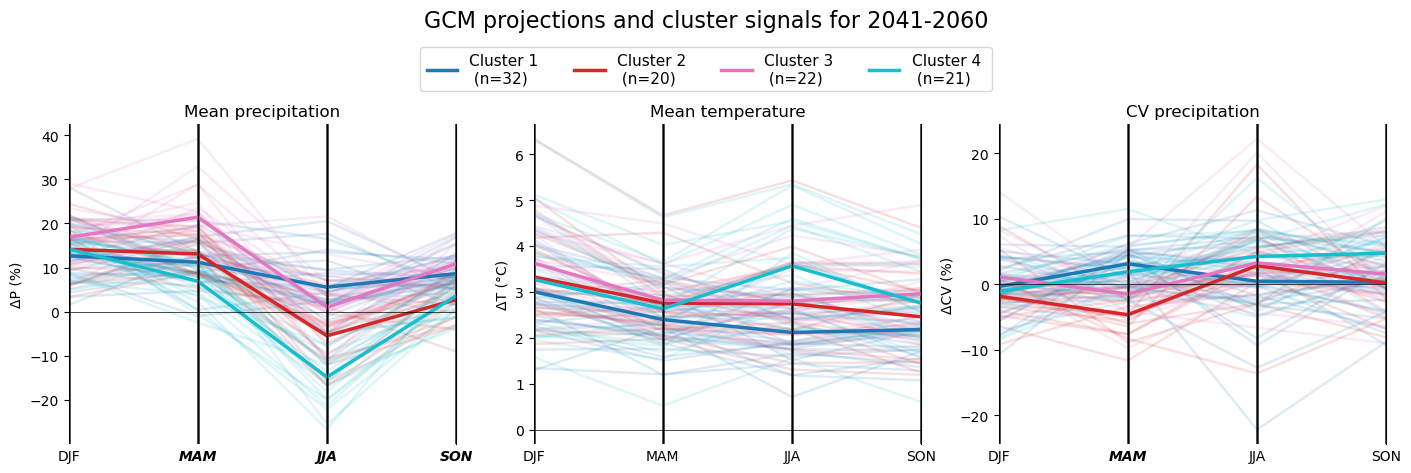

In [29]:
from pandas.plotting import parallel_coordinates

gcm_df = pd.read_csv(f'results/Latvia_all_models_dT_dP_dP_var.csv', index_col=0)
# divide all values for columns with 'dP' by 100 and add 1
gcm_df.loc[:, gcm_df.columns.str.contains('dP')] = gcm_df.loc[:, gcm_df.columns.str.contains('dP')]

# only keep row where index contains 2041
gcm_df = gcm_df[gcm_df.index.str.contains('2041')]

cluster_df = pd.read_csv(f'results/scenarios_for_mezotne.csv', index_col=0)
cluster_df = cluster_df.T
cluster_df['cluster_nr'] = cluster_df.index
# convert to int and add 1
cluster_df['cluster_nr'] = cluster_df['cluster_nr'].astype(int)  + 1

# convert dp to percentages
cluster_df.loc[:, cluster_df.columns.str.contains('dP')] = (cluster_df.loc[:, cluster_df.columns.str.contains('dP')] -1)* 100
cluster_df

vertical = False

if vertical:
    fig, axs = plt.subplots(3,1, figsize=(5,10))
    top_adjust = 0.84
    legend_cols = 3
else:
    fig, axs = plt.subplots(1,3, figsize=(17,5))
    top_adjust = 0.75
    legend_cols = 5

df_all = gcm_df
cluster_gcms = [gcm_df_cluster_1, gcm_df_cluster_2, gcm_df_cluster_3, gcm_df_cluster_4]



cmap = 'tab10'
norm = plt.Normalize(0, 4)
cmap = plt.cm.get_cmap(cmap, 4)
alpha_gcms = 0.15
cluster_mean_line_width = 2.5
gcm_line_width = 1.7

for i, cluster_group in enumerate(cluster_gcms):
    df_all = cluster_group
    df_all['dummy_class'] = 'GCM projections'
    df_all_no_yearly = df_all[[col for col in df_all.columns if 'year' not in col]]
    df_all_dp = df_all_no_yearly[[col for col in df_all_no_yearly.columns if 'dT' not in col and 'dP_var' not in col]]
    df_all_dp_var = df_all_no_yearly[[col for col in df_all_no_yearly.columns if 'dP_var' in col or 'dummy_class' in col]]
    df_all_dt = df_all_no_yearly[[col for col in df_all_no_yearly.columns if 'dP' not in col]]

    # for all numeric values in df_all_dp conver to percentage
    df_all_dp.loc[:, df_all_dp.columns.str.contains('dP')] = (df_all_dp.loc[:, df_all_dp.columns.str.contains('dP')] - 1) * 100
    df_all_dp_var.loc[:, df_all_dp_var.columns.str.contains('dP_var')] = (df_all_dp_var.loc[:, df_all_dp_var.columns.str.contains('dP_var')] - 1) * 100

    parallel_coordinates(df_all_dp, color=cmap(i), class_column="dummy_class", alpha=alpha_gcms, linewidth=gcm_line_width, ax=axs[0])
    parallel_coordinates(df_all_dt, color=cmap(i), class_column="dummy_class", alpha=alpha_gcms, linewidth=gcm_line_width, ax=axs[1])
    parallel_coordinates(df_all_dp_var, color=cmap(i), class_column="dummy_class", alpha=alpha_gcms, linewidth=gcm_line_width, ax=axs[2])

    # remove legend label
    axs[0].get_legend().remove()
    axs[1].get_legend().remove()
    axs[2].get_legend().remove()




cluster_df_dp = cluster_df[[col for col in cluster_df.columns if 'dT' not in col and 'dP_var' not in col]]
cluster_df_dp_var = cluster_df[[col for col in cluster_df.columns if 'dP_var' in col or 'cluster_nr' in col]]
cluster_df_dt = cluster_df[[col for col in cluster_df.columns if 'dP' not in col]]


parallel_coordinates(cluster_df_dp, class_column="cluster_nr", colormap=cmap, alpha=1, linewidth=cluster_mean_line_width, ax=axs[0])
parallel_coordinates(cluster_df_dt, class_column="cluster_nr", colormap=cmap, alpha=1, linewidth=cluster_mean_line_width, ax=axs[1])
parallel_coordinates(cluster_df_dp_var, class_column="cluster_nr", colormap=cmap, alpha=1, linewidth=cluster_mean_line_width, ax=axs[2])

# create a hline at 0
for i in range(3):
    axs[i].axhline(0, color='black', linewidth=0.5)
    # remove all spines
    axs[i].spines['top'].set_color('none')
    axs[i].spines['bottom'].set_color('none')
    axs[i].spines['left'].set_color('none')
    # axs[i].spines['right'].set_color('none')
    # # remove background grid
    axs[i].grid(False)

# 
axs[0].set_ylabel('ΔP (%)')
axs[1].set_ylabel('ΔT (°C)')
axs[2].set_ylabel('ΔCV (%)')

# set titles
axs[0].set_title('Mean precipitation')
axs[1].set_title('Mean temperature')
axs[2].set_title('CV precipitation')

# set overall title
fig.suptitle(f'GCM projections and cluster signals for {timeframe}-{int(timeframe)+19}', fontsize=16)

# only keep one legend and move to top of figure
handles, labels = axs[0].get_legend_handles_labels()
# add string to label except for first label
labels = ['GCM projections'] #+ [f'Cluster {label}, n={nr_gcms_in_cluster}' for label in labels[1:]]

for i in range(len(cluster_gcms)):
    nr_gcms_in_cluster = len(cluster_gcms[i])
    labels.append(f'Cluster {i+1} \n (n={nr_gcms_in_cluster})')

fig.legend(handles[-4:], labels[-4:], loc='upper center', ncol=legend_cols, fontsize=11, bbox_to_anchor=(0.5, 0.92))

# move legend down
fig.subplots_adjust(top=top_adjust)


for ax in axs:
    # delete legend
    ax.get_legend().remove()
    # get xlables
    xtick_labels = ['DJF', 'MAM', 'JJA', 'SON']
    ax.set_xticks(range(len(xtick_labels)))
    ax.set_xticklabels(xtick_labels)
    ax.tick_params(axis='x', length=0)


if vertical:
    # remove xlabels from all but last
    for ax in axs[:-1]:
        xtick_labels = ['', '', '', '']
        ax.set_xticks(range(len(xtick_labels)))
        ax.set_xticklabels(xtick_labels)

# Make clustered features bold and italix (mean precip MAM, mean precip JJA, mean precip SON, CV MAM)
for ax in axs:
    # get title labels
    title = ax.get_title()
    for i, col in enumerate(ax.get_xticklabels()):
        if title == 'Mean precipitation':
            if col.get_text() in ['MAM', 'JJA', 'SON']:
                col.set_fontweight('bold')
                col.set_fontstyle('italic')
        if title == 'CV precipitation':
            if col.get_text() in ['MAM']:
                col.set_fontweight('bold')
                col.set_fontstyle('italic')
